In [167]:
from other_function import load_object, RecurseListDir
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import cvxpy as cvx
import math

In [168]:
NAMEPREFIX = "./result/20241126_123428"
N_FRAMES = 4 
N_SLOTS = 4
N_RBS = 3

# FILL_COLORS = ['lightgreen', 'lightyellow', 'lightpink','lightblue', 'lightgrey']
FILL_COLORS = ['lightgreen', 'lightyellow', 'lightpink']
# RU_COLORS = ['darkgreen','darkgoldenrod', 'mediumvioletred', 'darkblue', 'grey']
RU_COLORS = ['darkgreen','darkgoldenrod', 'mediumvioletred']
# RU_COLORS = ['red','green', 'blue']
radius_in = 100                   
radius_out = 1000   

In [169]:
# LOAD DATA
G = load_object(f"{NAMEPREFIX}_physicalnet.pkl.gz")
coords_RUs = load_object(f"{NAMEPREFIX}_coords_RUs.pkl.gz")

coords_UEs_frames = []
gain_frames = []
solution_longterm_frames = []
coords_UEs_frames_slots = []
solution_shortterm_slots_frames = []
gain_slots_frames = []
for f in range(N_FRAMES):
    coords_UEs_frames.append(
        load_object(f"{NAMEPREFIX}_coords_UEs_f{f}.pkl.gz")
    )
    solution_longterm_frames.append(
        load_object(f"{NAMEPREFIX}_solution_longterm_f{f}.pkl.gz")
    )
    gain_frames.append(
        load_object(f"{NAMEPREFIX}_solution_gain_f{f}.pkl.gz")
    )
    coords_UEs_slots = []
    solution_shortterm_slots = []
    for t in range(N_SLOTS):
        coords_UEs_slots.append(
            load_object(f"{NAMEPREFIX}_coords_UEs_f{f}_t{t}.pkl.gz")
        )
        solution_shortterm_slots.append(
            load_object(f"{NAMEPREFIX}_solution_shortterm_f{f}_t{t}.pkl.gz")
        )
        gain_slots_frames.append(
            load_object(f"{NAMEPREFIX}_solution_gain_f{f}_t{t}.pkl.gz")
        )
    coords_UEs_frames_slots.append(coords_UEs_slots)
    solution_shortterm_slots_frames.append(solution_shortterm_slots)

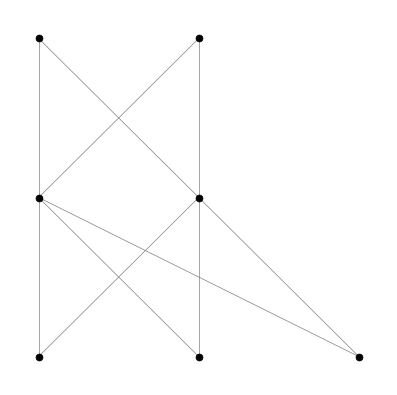

In [170]:
# NETWORK TOPO
x = 0
y = [100,50,0]
x_step = 50
count_CU = 0
count_DU = 0
count_RU = 0
loc = {}
for node in G.nodes:
    name = str(node)
    if name.startswith("CU"):
        loc_x = x + count_CU * x_step
        loc_y = y[0]
        count_CU += 1
        loc.update({name:(loc_x, loc_y)})
    if name.startswith("DU"):
        loc_x = x + count_DU * x_step
        loc_y = y[1]
        count_DU += 1
        loc.update({name:(loc_x, loc_y)})
    if name.startswith("RU"):
        loc_x = x + count_RU * x_step
        loc_y = y[2]
        count_RU += 1
        loc.update({name:(loc_x, loc_y)})
        
plt.figure(figsize=(10,10), dpi=50)
nx.draw_networkx(
    G, pos=loc,
    node_color="k",
    with_labels=False,
    edge_color="grey",
    node_shape="o",
    node_size=100
)
plt.box(False)
    # plt.savefig(f"{FIGPATH}/easy_{name}.pdf", bbox_inches="tight")
plt.show()

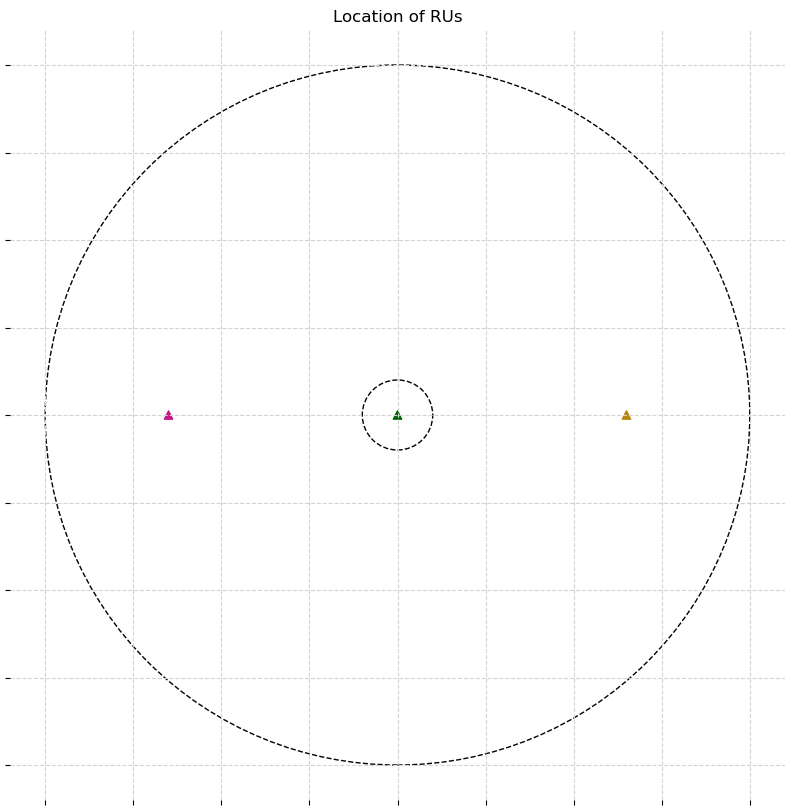

In [171]:
# RU LOCATIONS
def basemap(name="Location of RUs"):
    plt.figure(figsize=(10,10), dpi=100)
    ax = plt.gca()
    ax.cla()
    in_ras = plt.Circle((0,0), radius=radius_in, fill=False, linestyle="--")
    out_ras = plt.Circle((0,0), radius=radius_out, fill=False, linestyle="--")
    ax.add_patch(in_ras)
    ax.add_patch(out_ras)
    plt.scatter(
        [ru[0] for ru in coords_RUs],
        [ru[1] for ru in coords_RUs], 
        marker="^",
        c=RU_COLORS
    )
    ax.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.grid(color='lightgrey', linestyle='--', zorder=-100)
    plt.box(False)
    plt.title(name)
    
basemap()
plt.show()

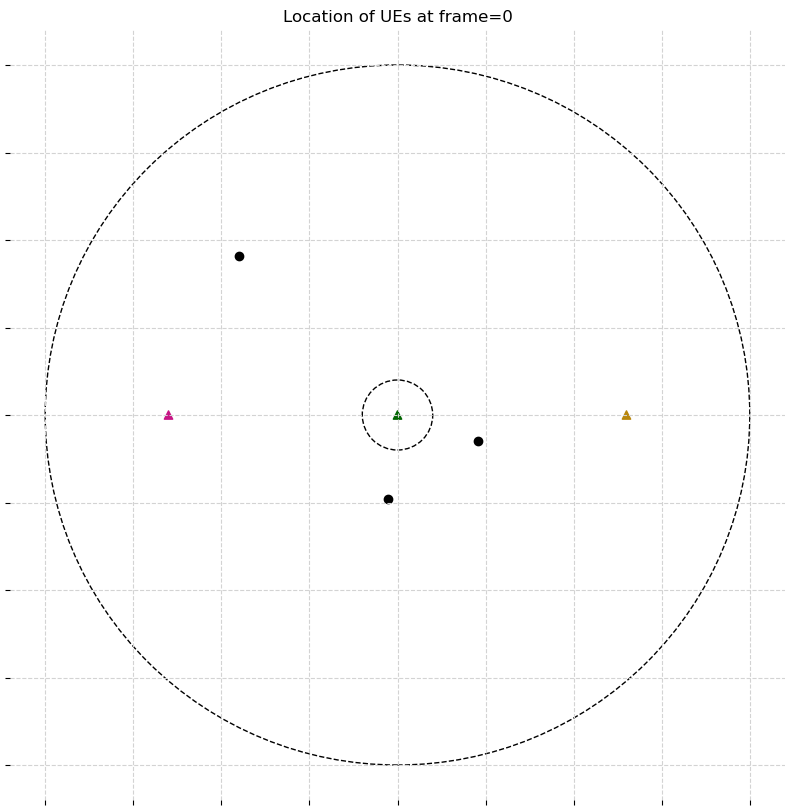

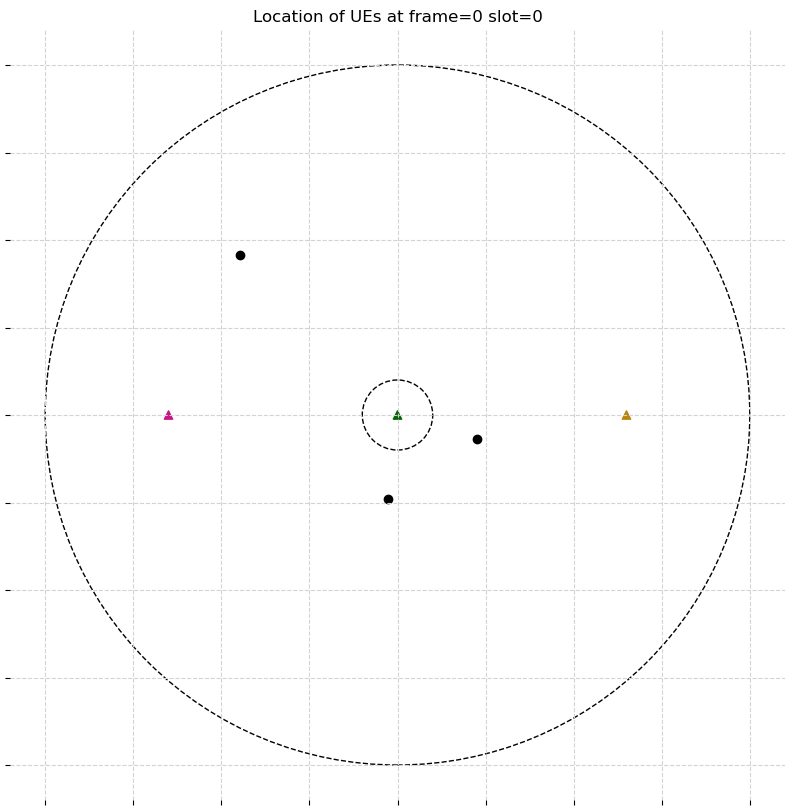

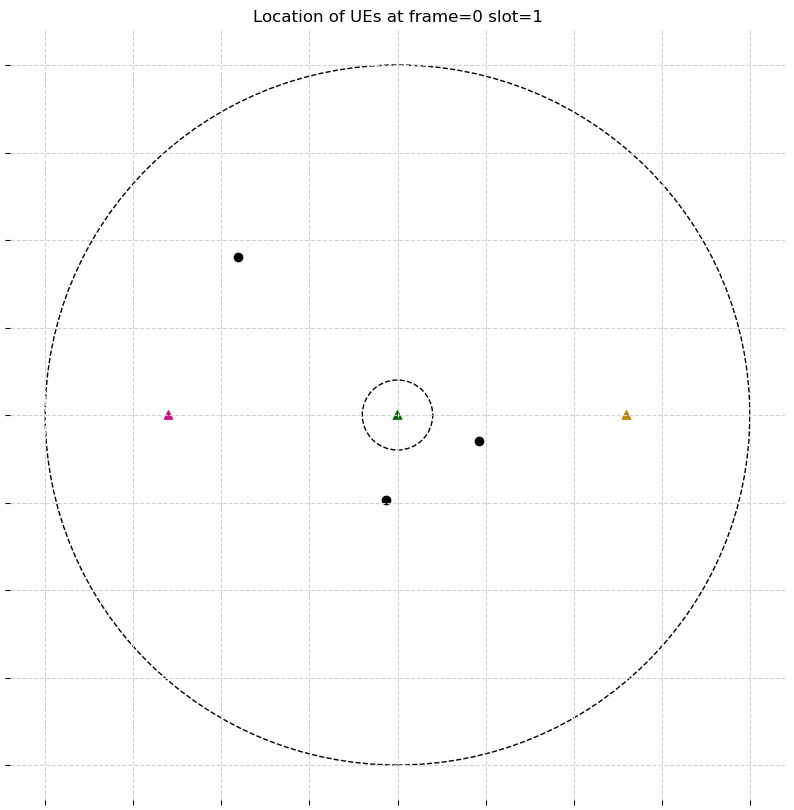

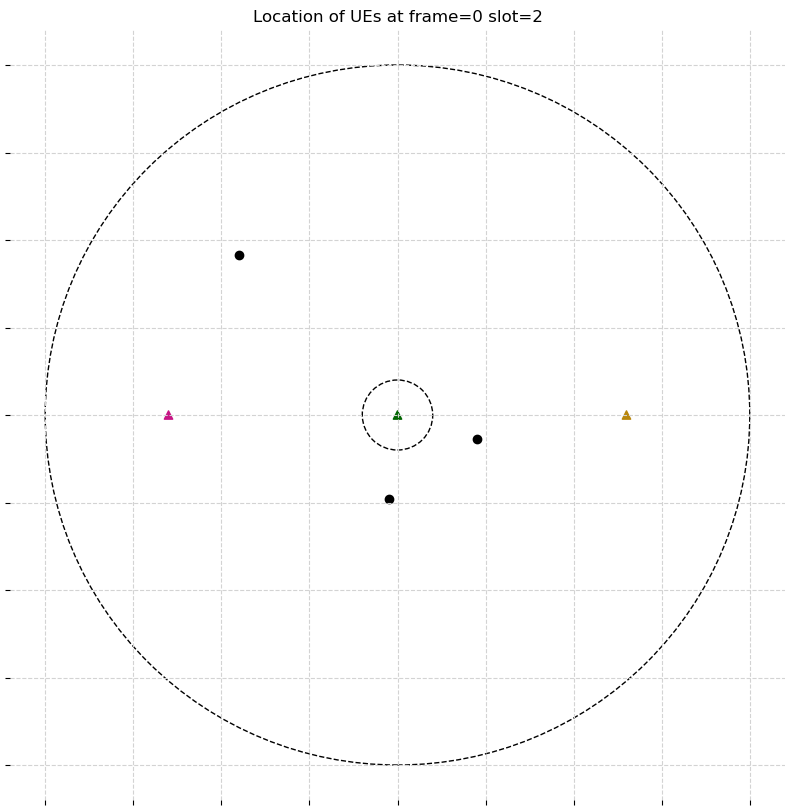

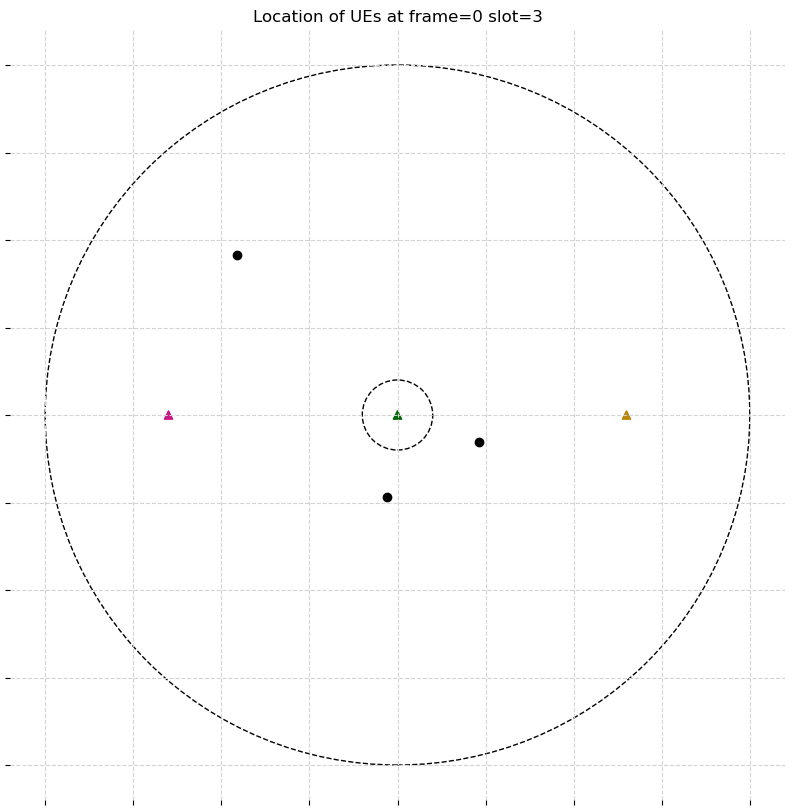

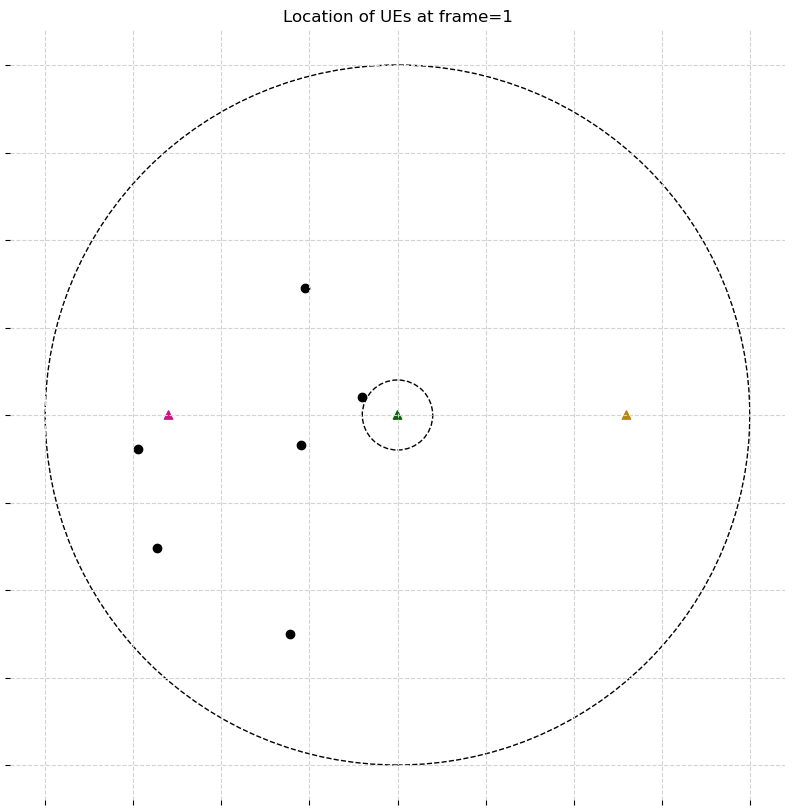

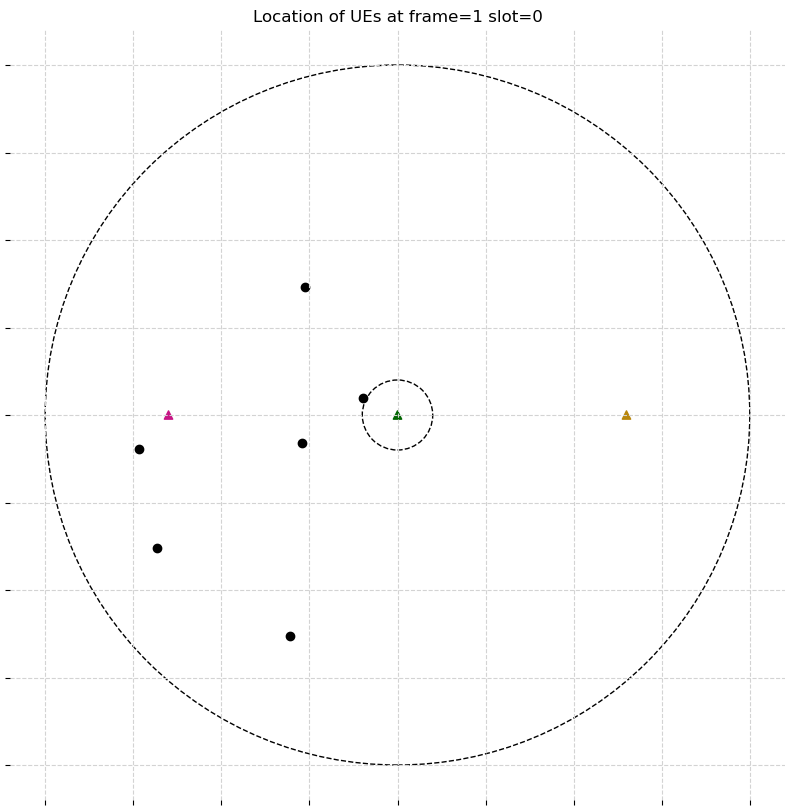

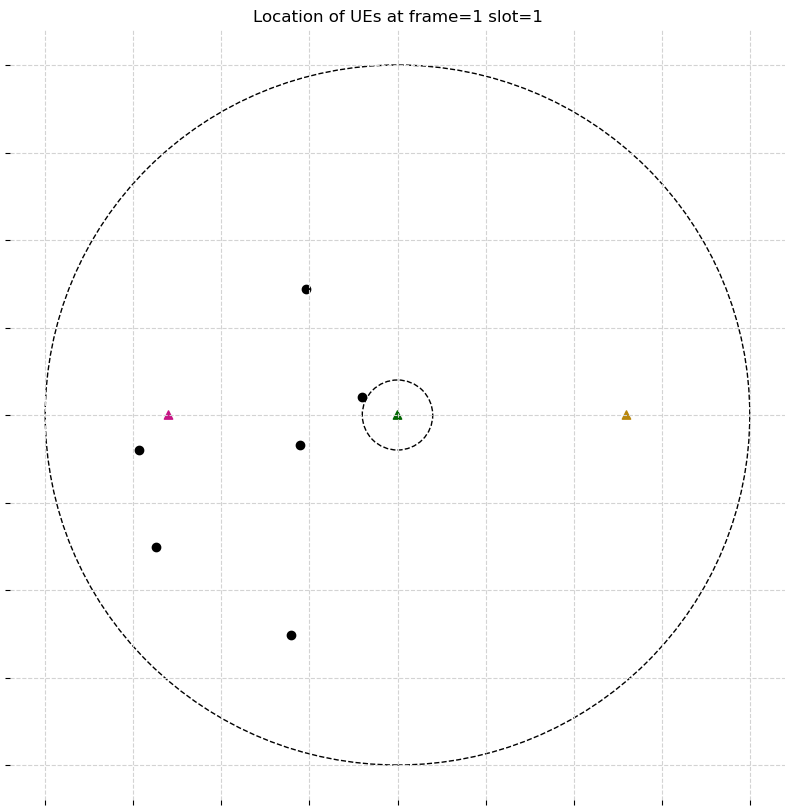

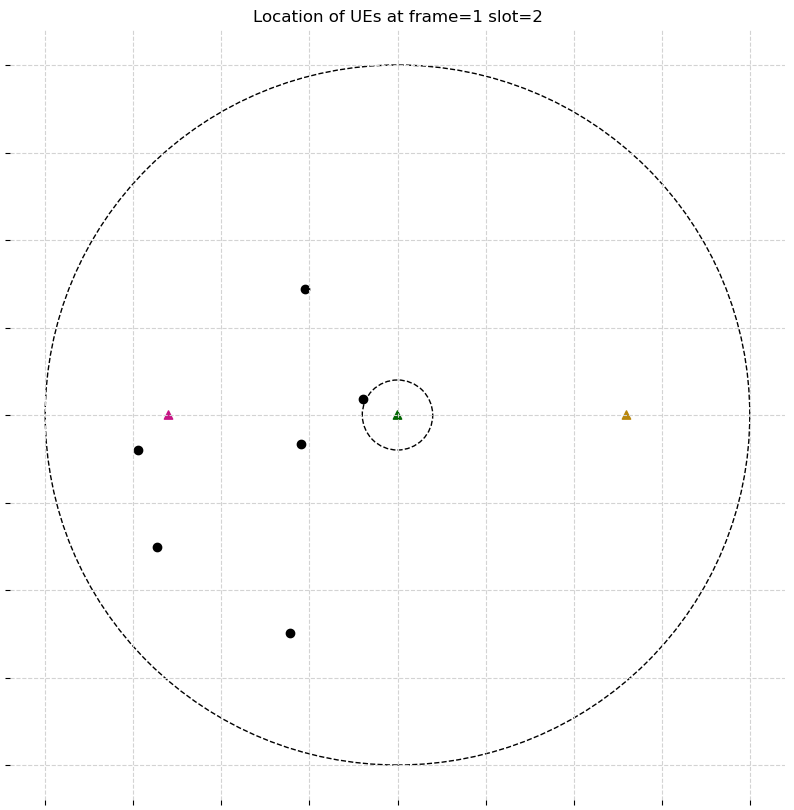

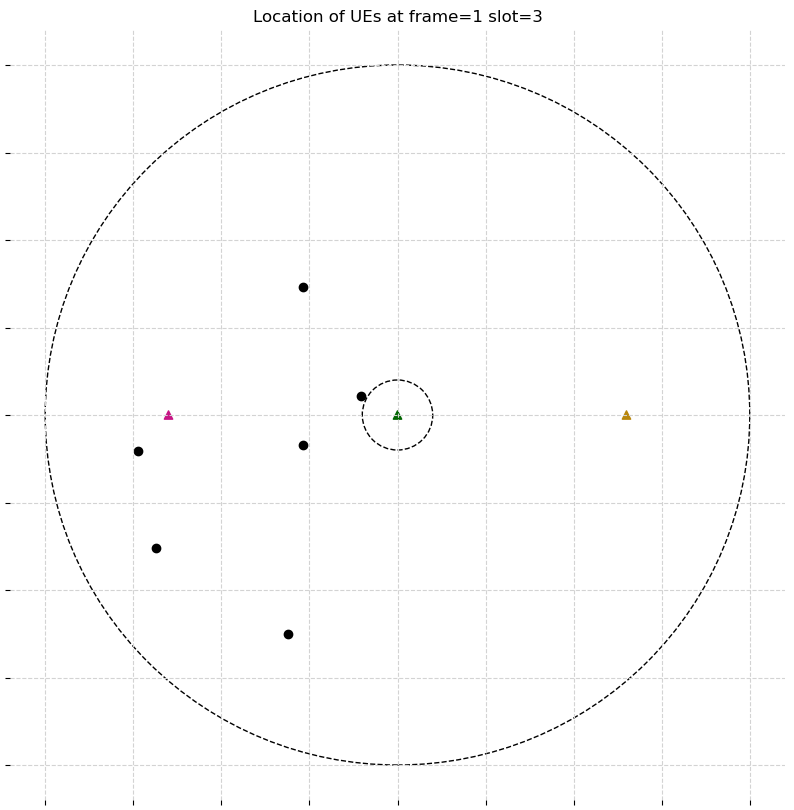

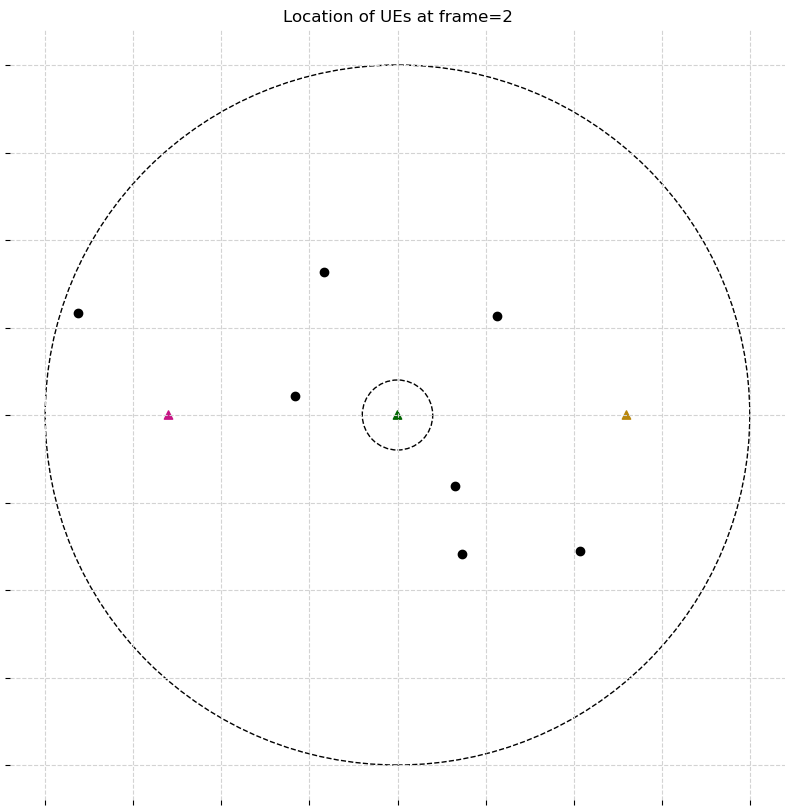

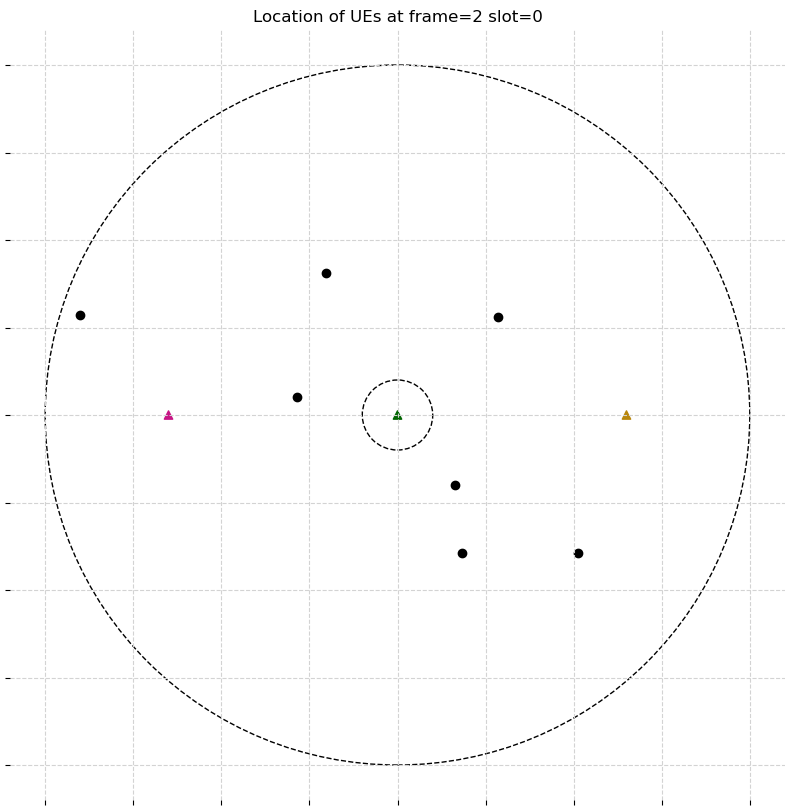

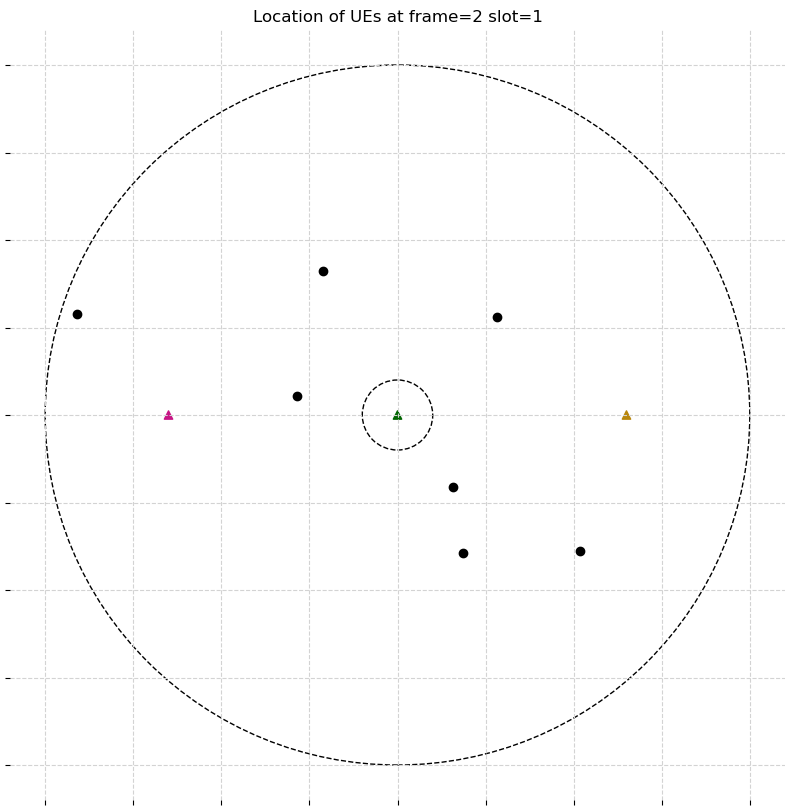

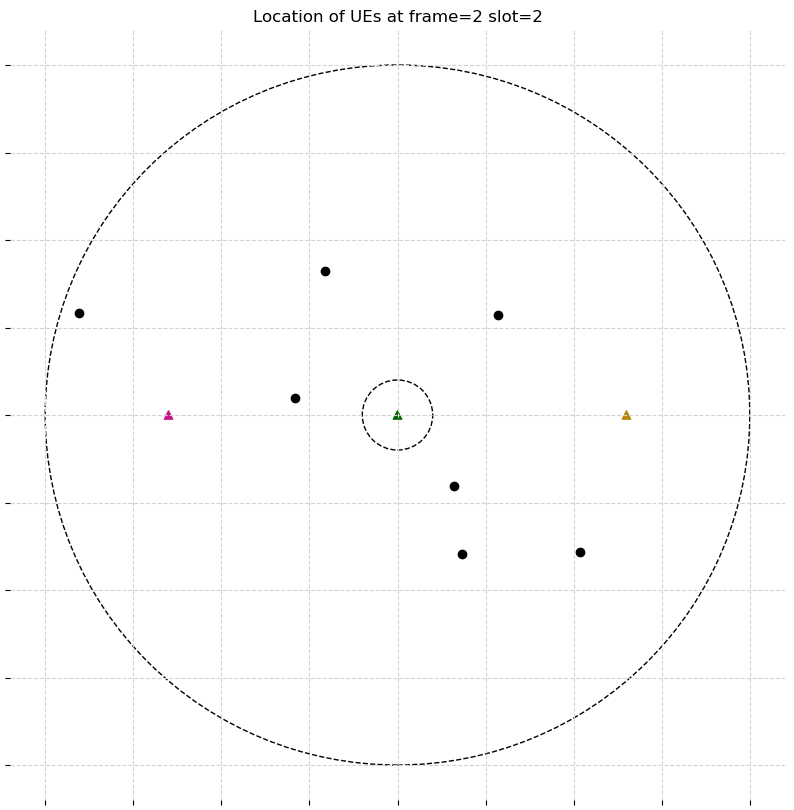

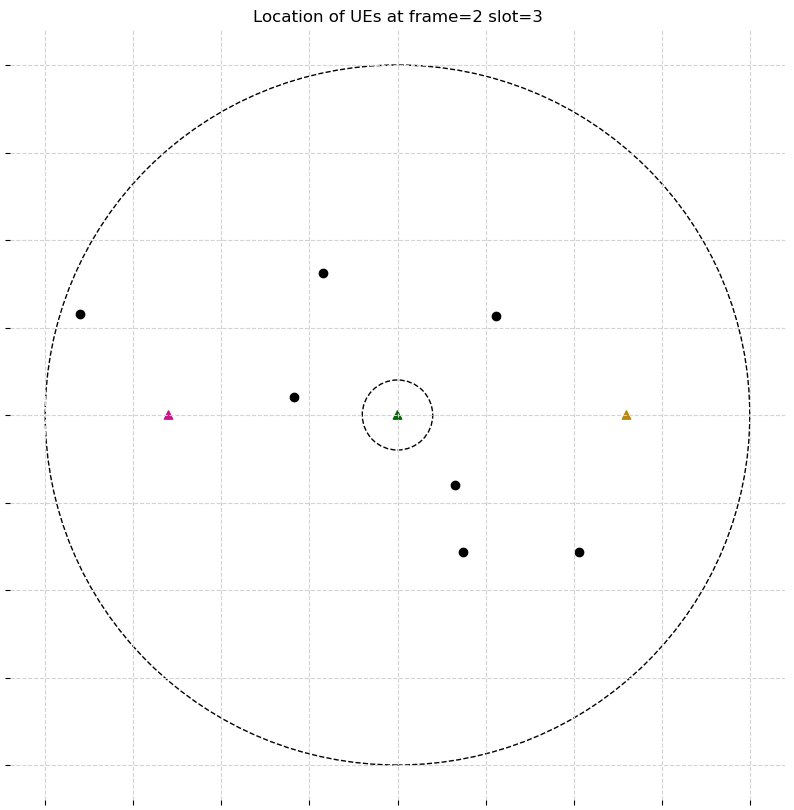

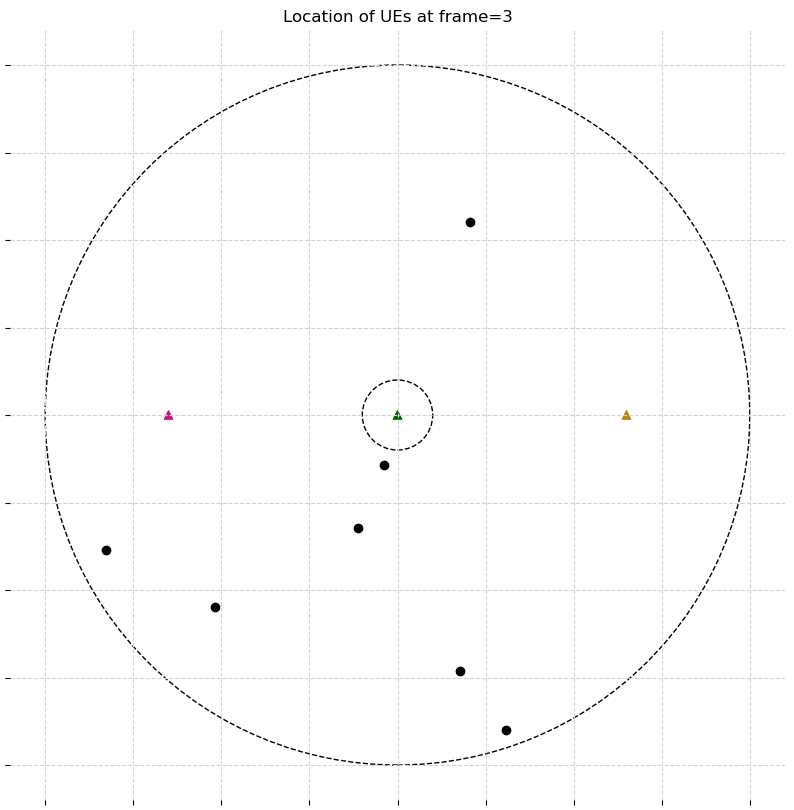

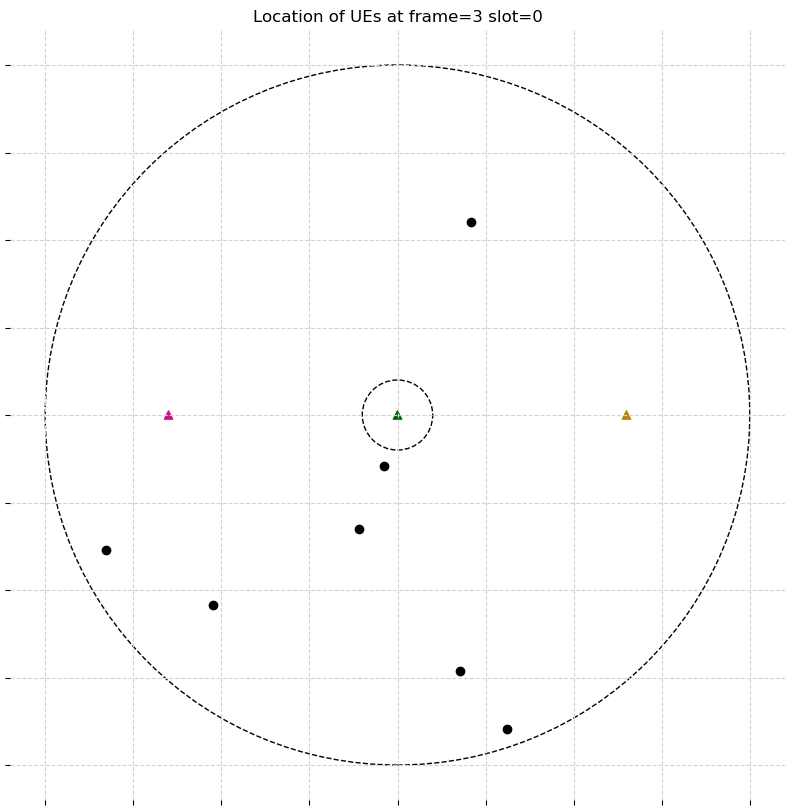

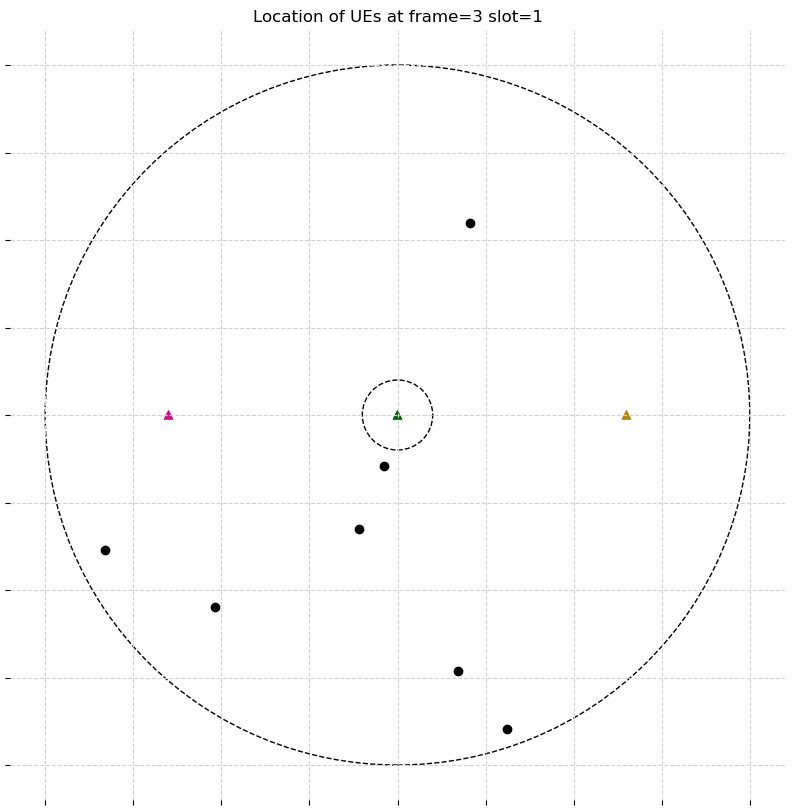

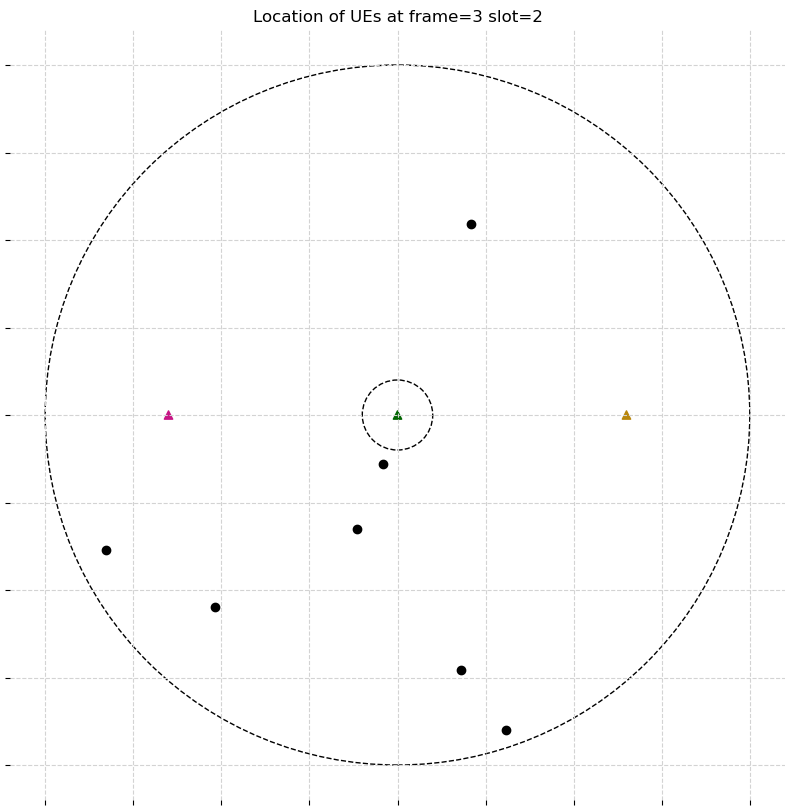

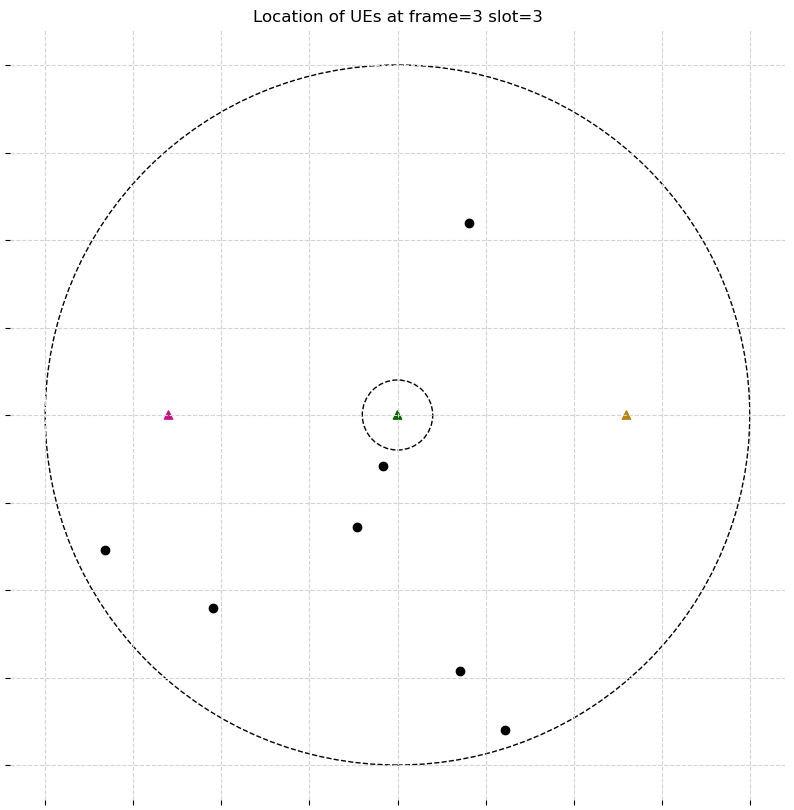

In [172]:
# LOCATIONS
for f in range(N_FRAMES):
    basemap(f"Location of UEs at frame={f}")
    plt.scatter(
        [ue[0] for ue in coords_UEs_frames[f]],
        [ue[1] for ue in coords_UEs_frames[f]],
        marker="o",
        c="k"
    )
    plt.show()
    for t in range(N_SLOTS):
        basemap(f"Location of UEs at frame={f} slot={t}")
        plt.scatter(
            [ue[0] for ue in coords_UEs_frames_slots[f][t]],
            [ue[1] for ue in coords_UEs_frames_slots[f][t]],
            marker="o",
            c="k"
        )
        plt.show()

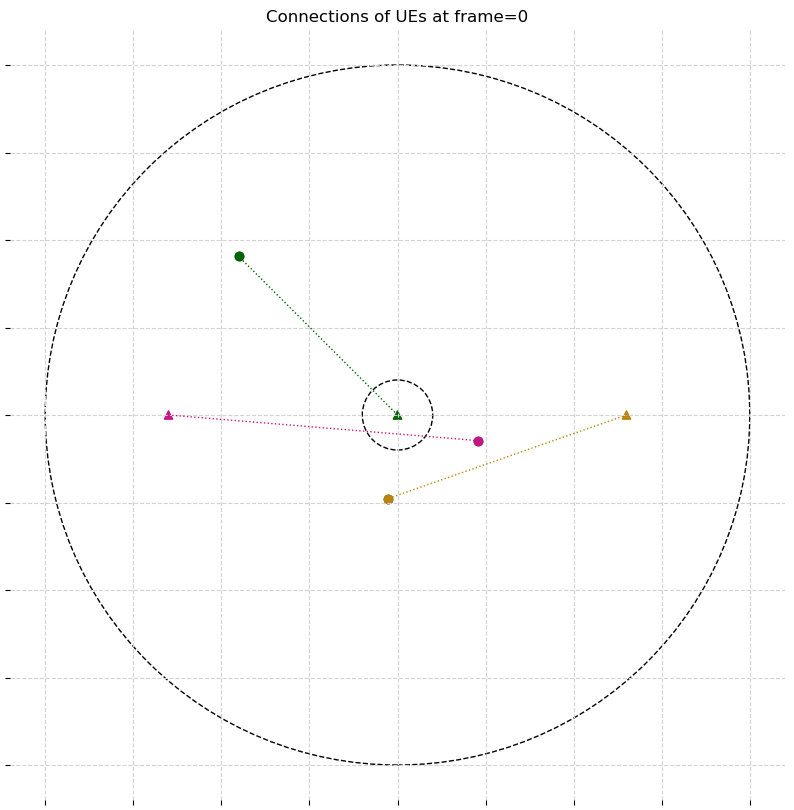

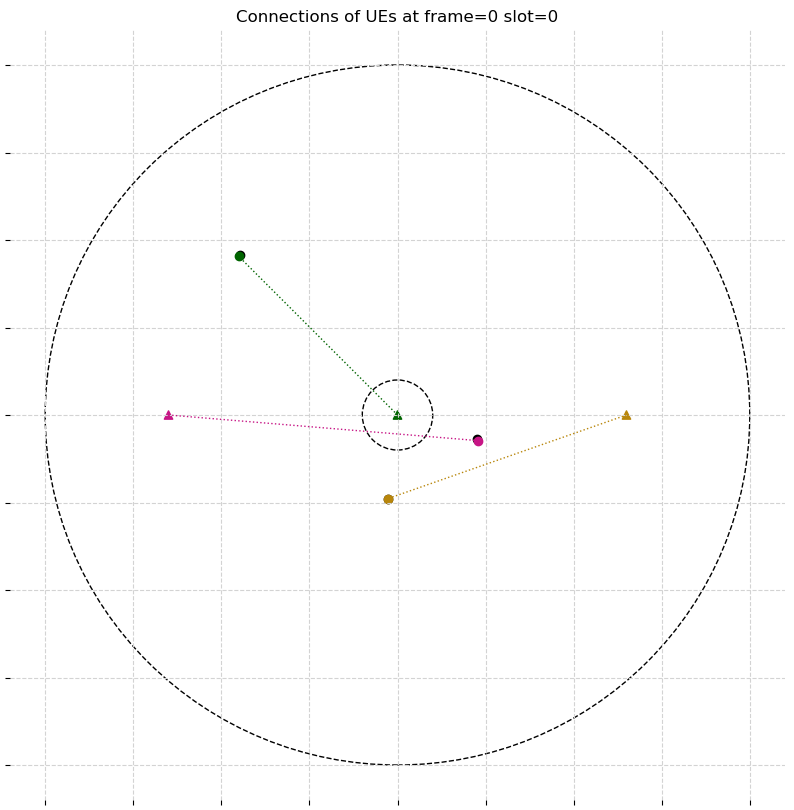

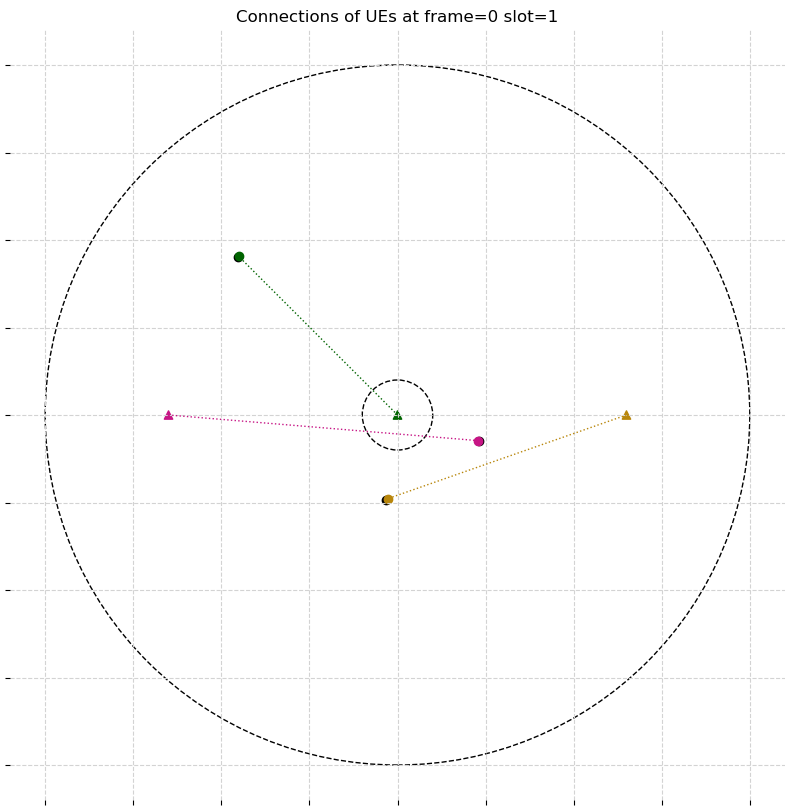

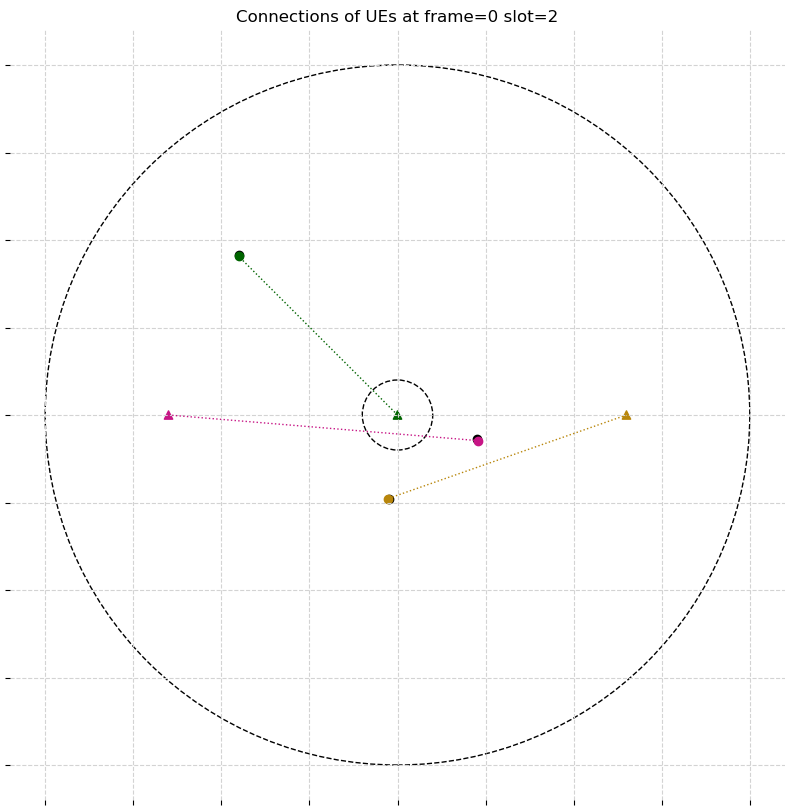

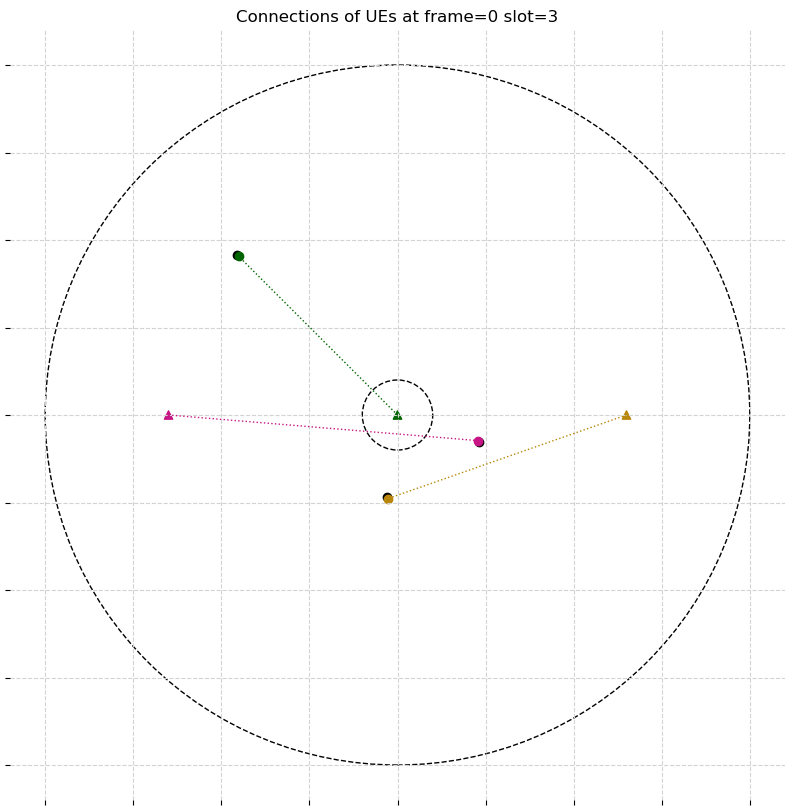

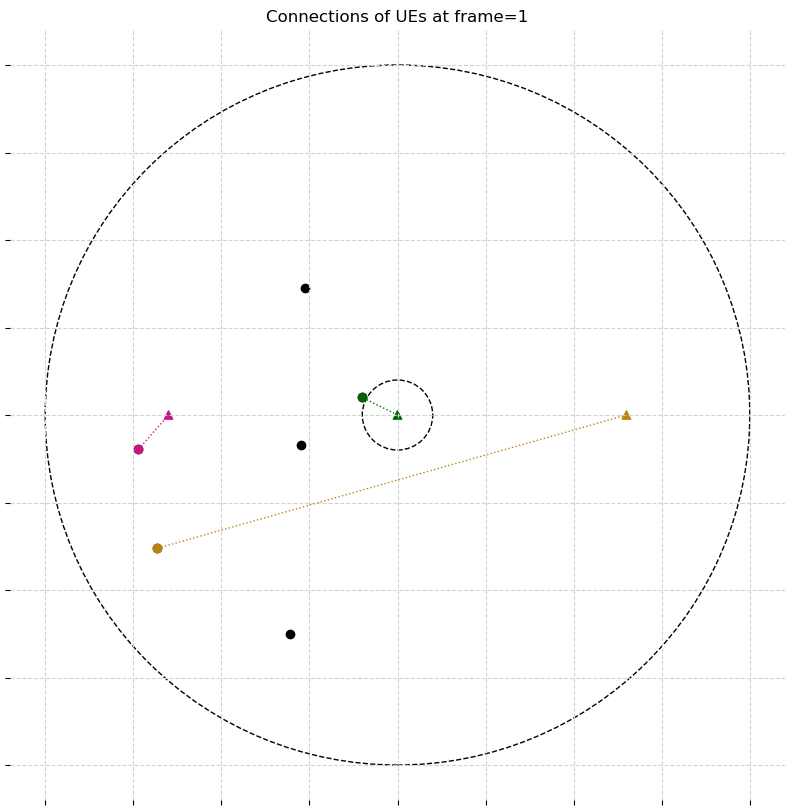

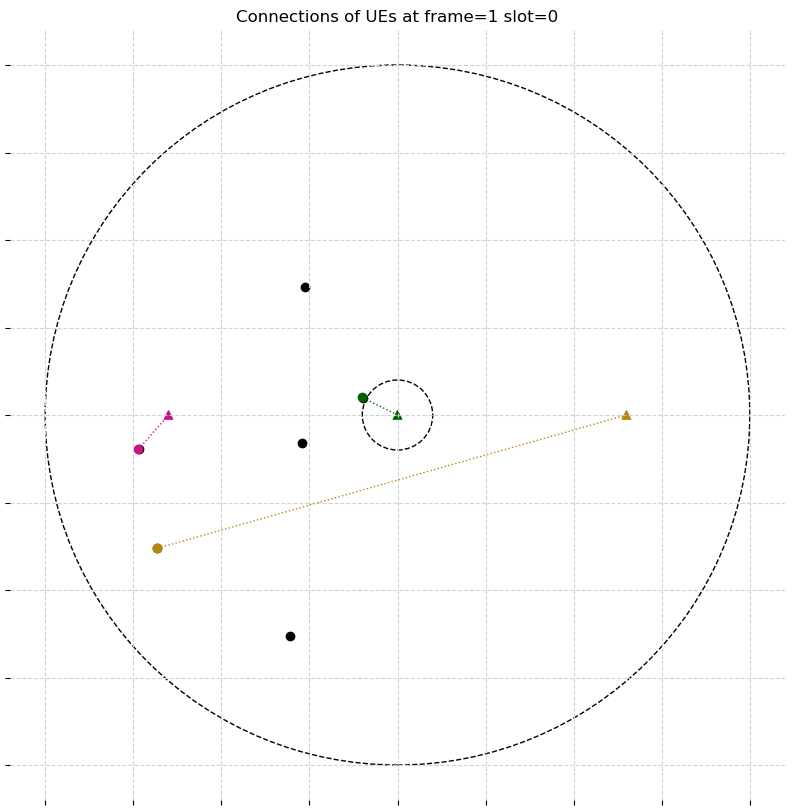

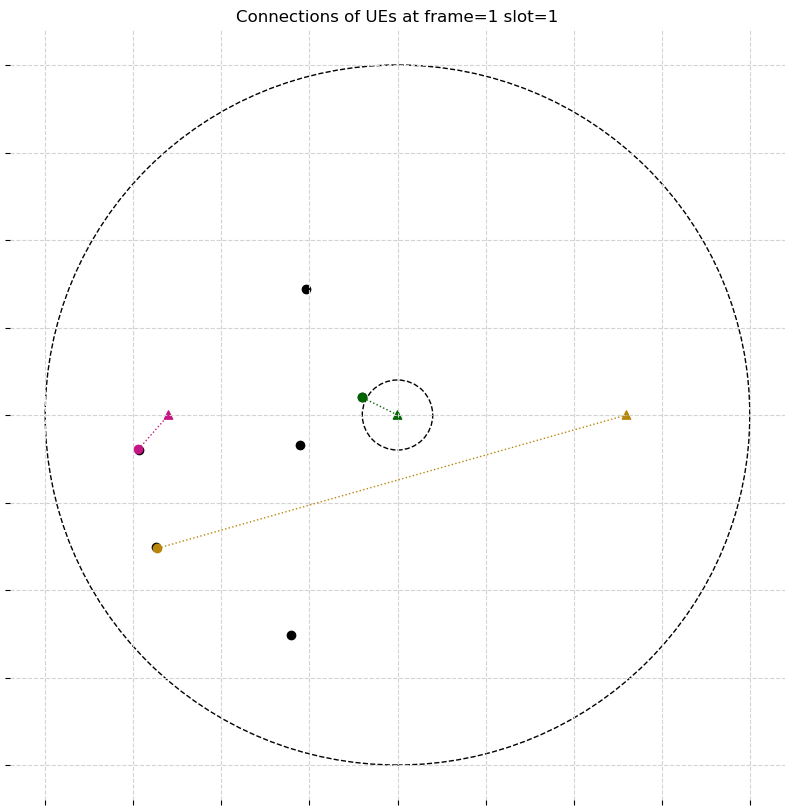

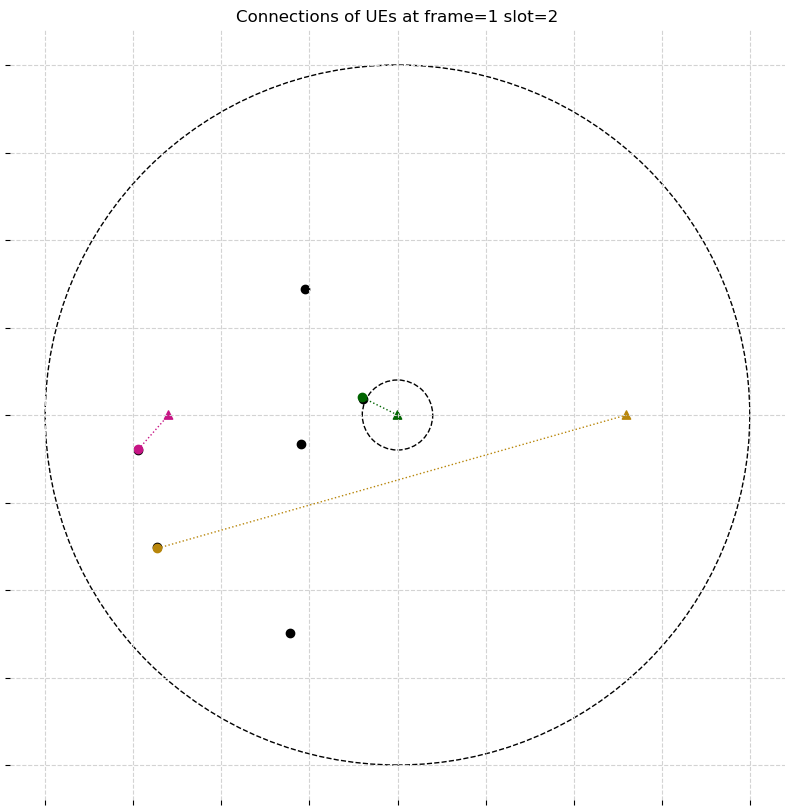

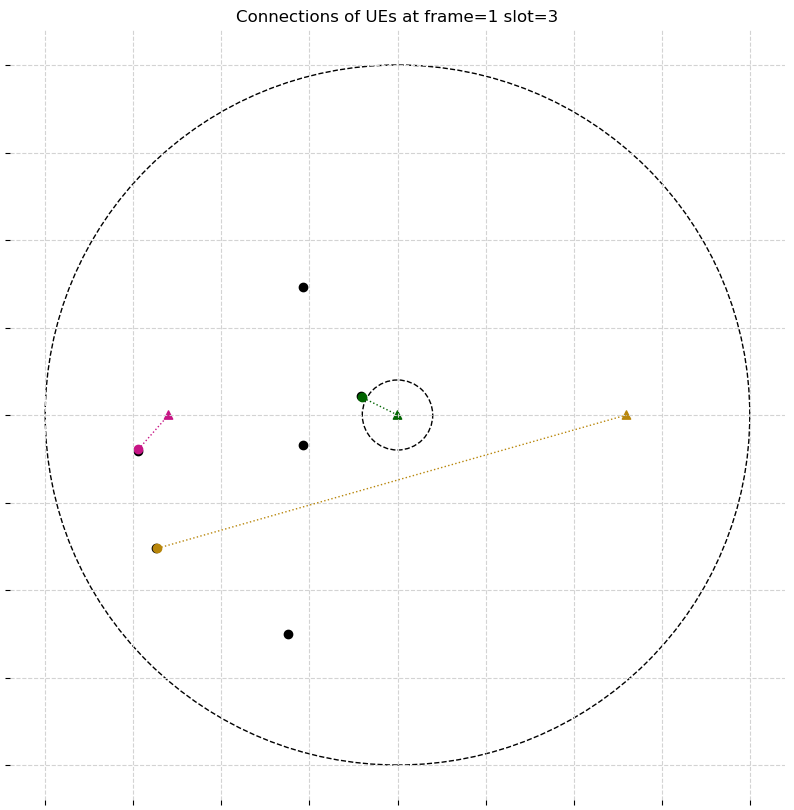

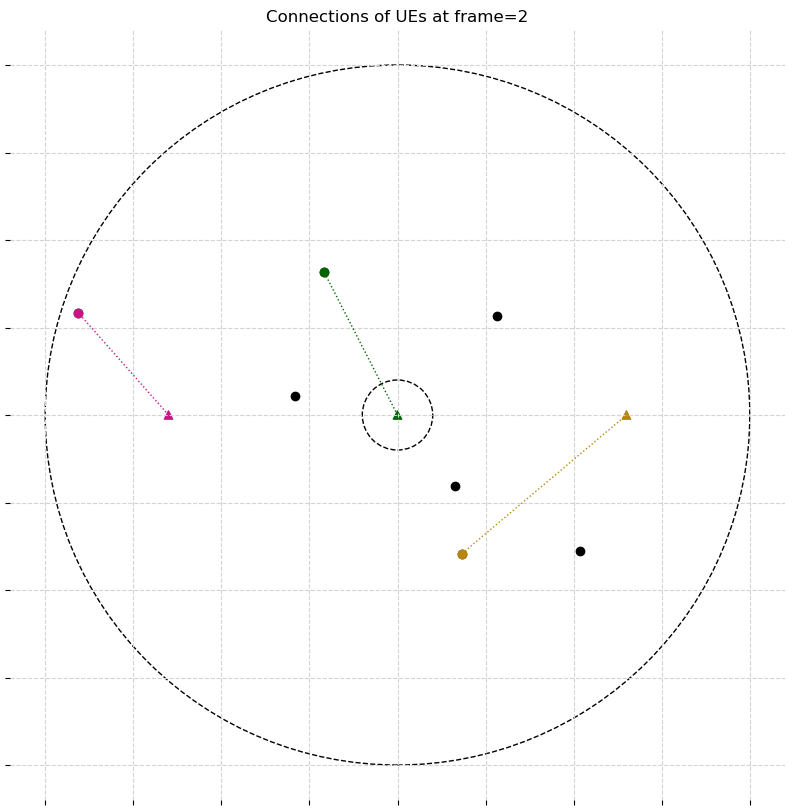

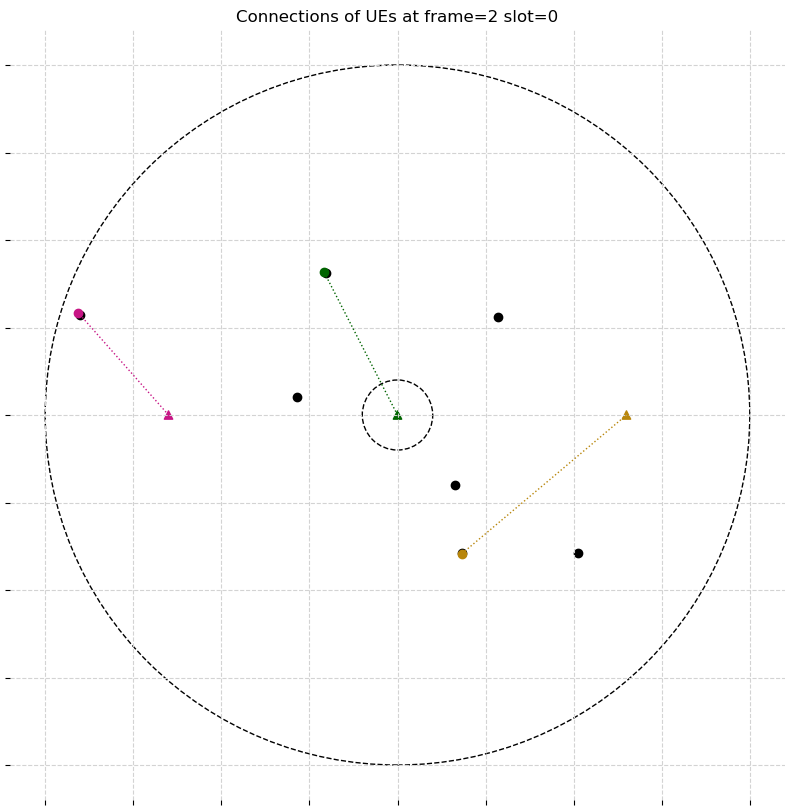

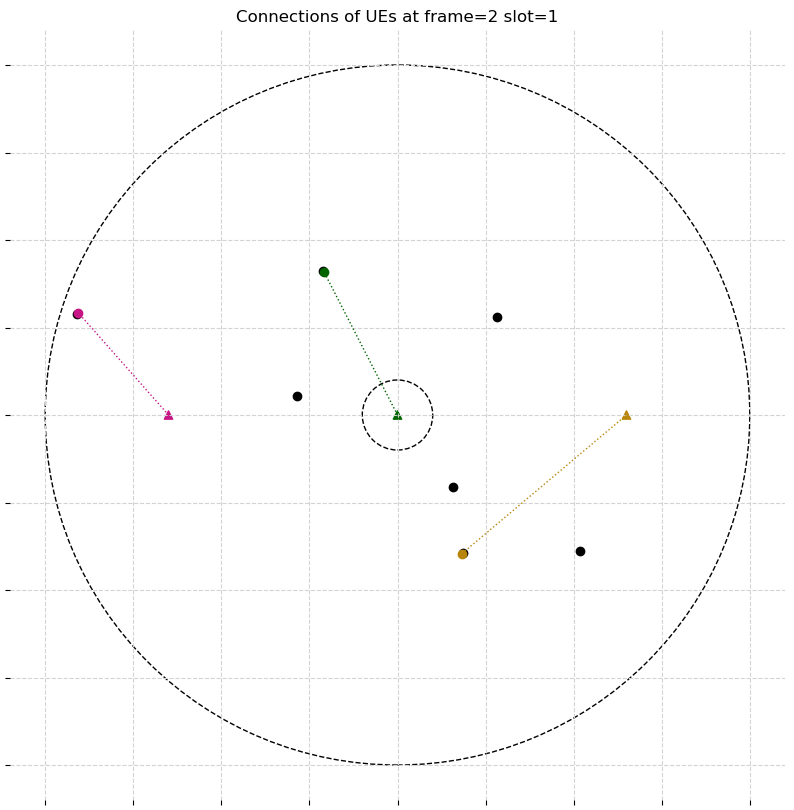

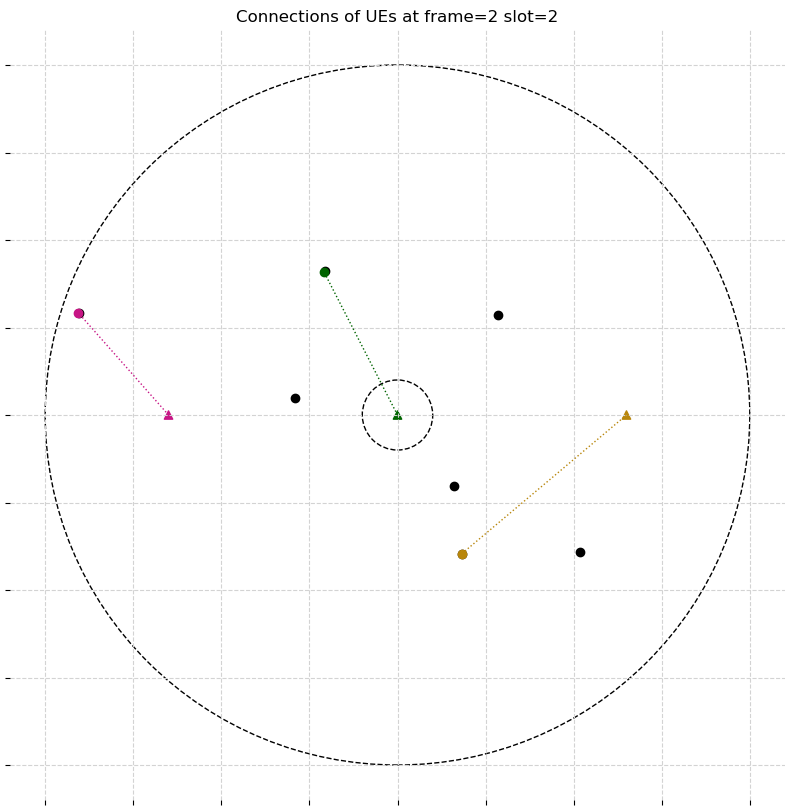

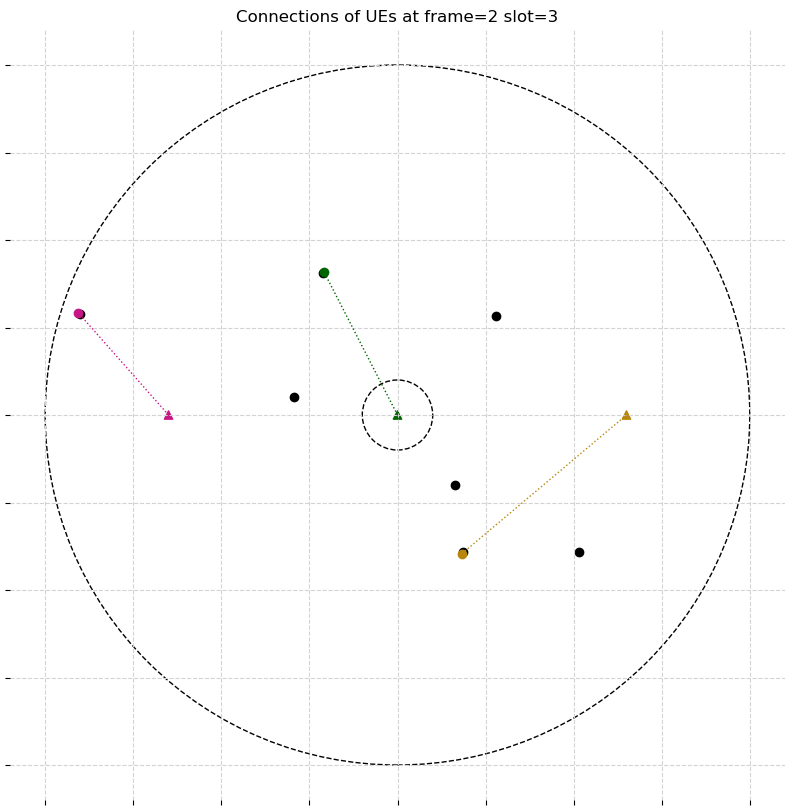

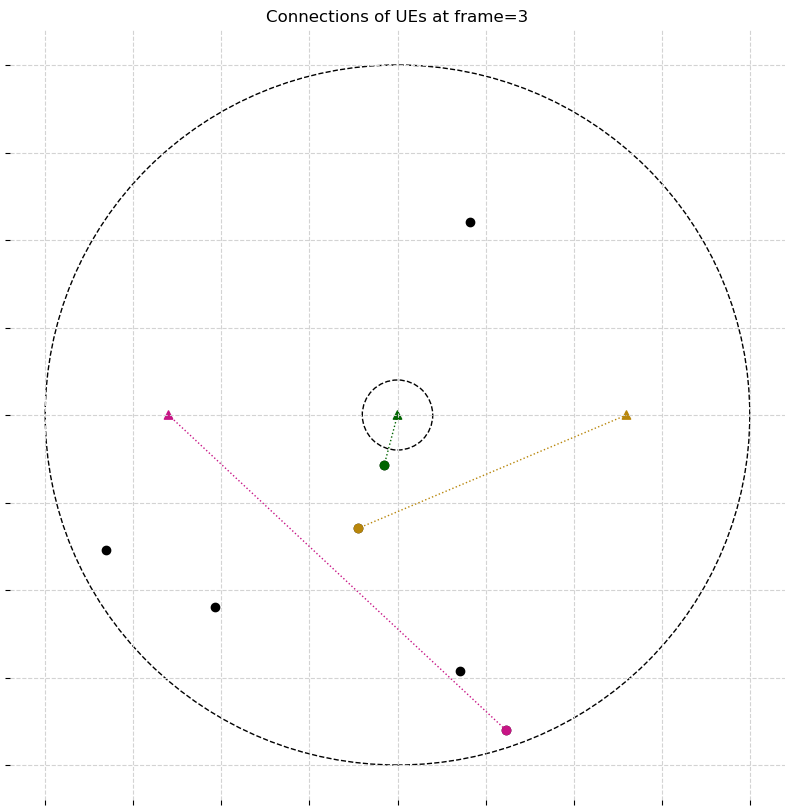

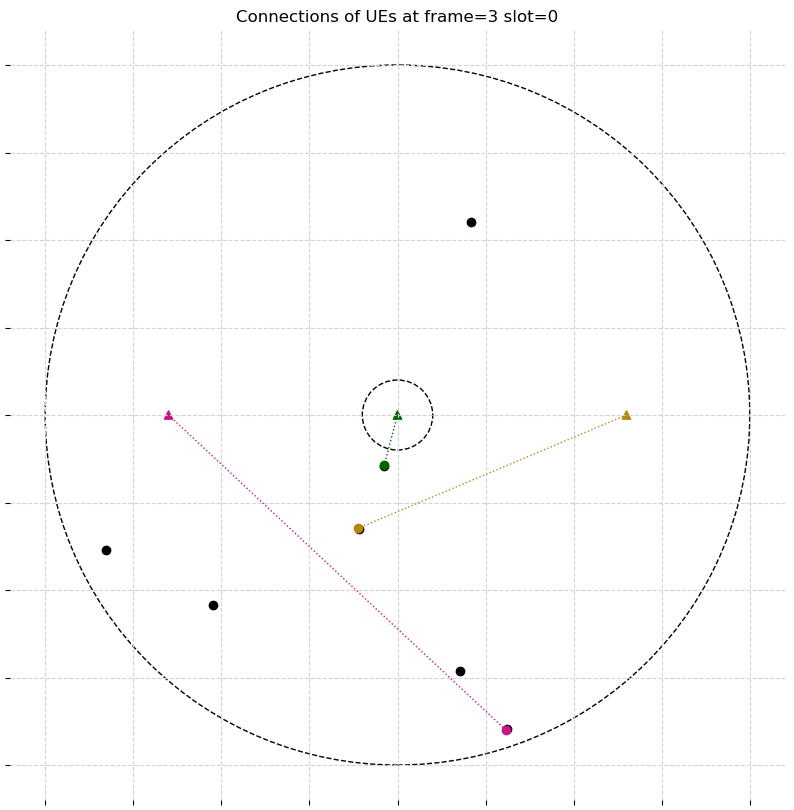

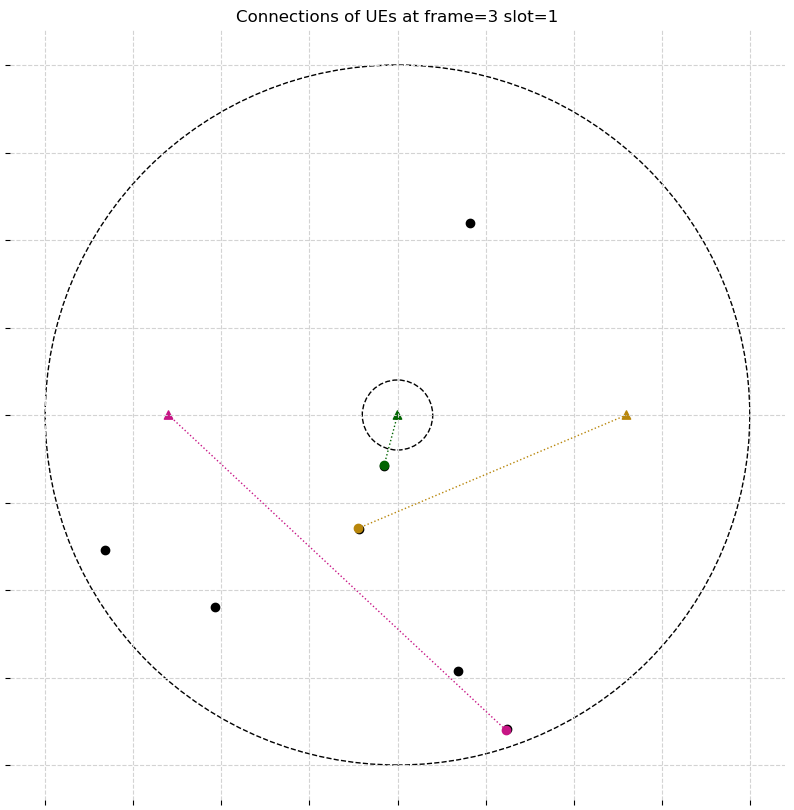

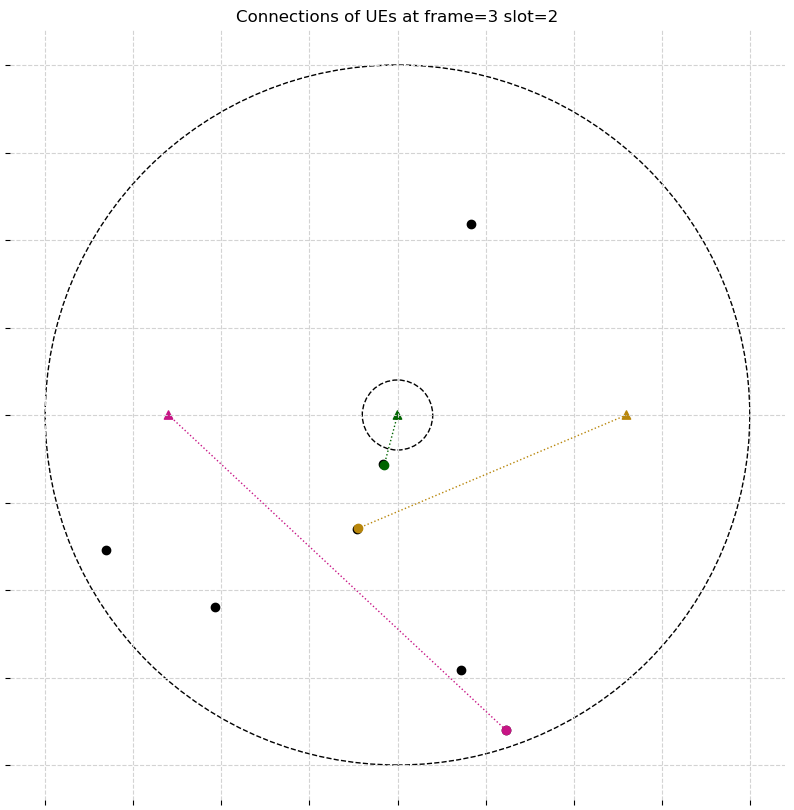

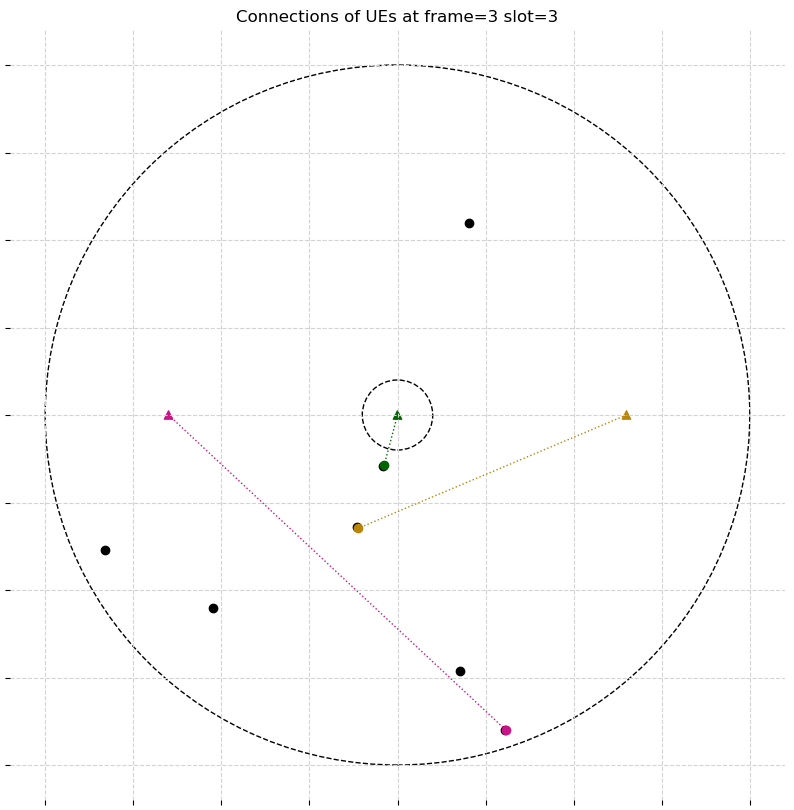

In [173]:
# CONNECTIONS
for f in range(N_FRAMES):
    basemap(f"Connections of UEs at frame={f}")
    plt.scatter(
        [ue[0] for ue in coords_UEs_frames[f]],
        [ue[1] for ue in coords_UEs_frames[f]],
        marker="o",
        c="k"
    )
    longterm_solution = solution_longterm_frames[f]
    pi_sk, z_ib_sk, p_ib_sk, mu_ib_sk, phi_i_sk, phi_j_sk, phi_m_sk = longterm_solution
    for i in range(len(z_ib_sk)):
        for b in range(len(z_ib_sk[i])):
            for s in range(len(z_ib_sk[i][b])):
                for k in range(len(z_ib_sk[i][b][s])):
                    if round(z_ib_sk[i,b,s,k].value) > 0:
                        x = [coords_RUs[i][0], coords_UEs_frames[f][k][0]]
                        y = [coords_RUs[i][1], coords_UEs_frames[f][k][1]]
                        plt.plot(x, y, linestyle="dotted", linewidth=1, c=RU_COLORS[i])
                        plt.scatter(coords_UEs_frames[f][k][0], coords_UEs_frames[f][k][1], c=RU_COLORS[i])
    plt.show()
    for t in range(N_SLOTS):
        basemap(f"Connections of UEs at frame={f} slot={t}")
        plt.scatter(
            [ue[0] for ue in coords_UEs_frames_slots[f][t]],
            [ue[1] for ue in coords_UEs_frames_slots[f][t]],
            marker="o",
            c="k"
        )
        shortterm_solution = solution_shortterm_slots_frames[f][t]
        short_pi_sk, short_z_ib_sk, short_p_ib_sk, short_mu_ib_sk = shortterm_solution
        for i in range(len(short_z_ib_sk)):
            for b in range(len(short_z_ib_sk[i])):
                for s in range(len(short_z_ib_sk[i][b])):
                    for k in range(len(short_z_ib_sk[i][b][s])):
                        if round(short_z_ib_sk[i,b,s,k].value) > 0:
                            x = [coords_RUs[i][0], coords_UEs_frames[f][k][0]]
                            y = [coords_RUs[i][1], coords_UEs_frames[f][k][1]]
                            plt.plot(x, y, linestyle="dotted", linewidth=1, c=RU_COLORS[i])
                            plt.scatter(coords_UEs_frames[f][k][0], coords_UEs_frames[f][k][1], c=RU_COLORS[i])
        plt.show()

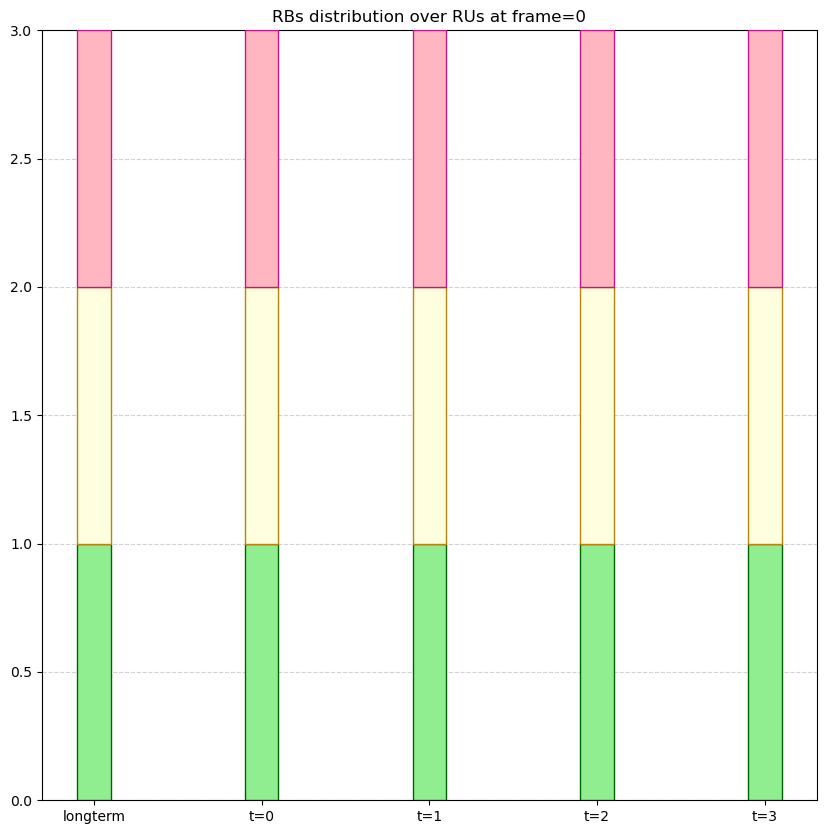

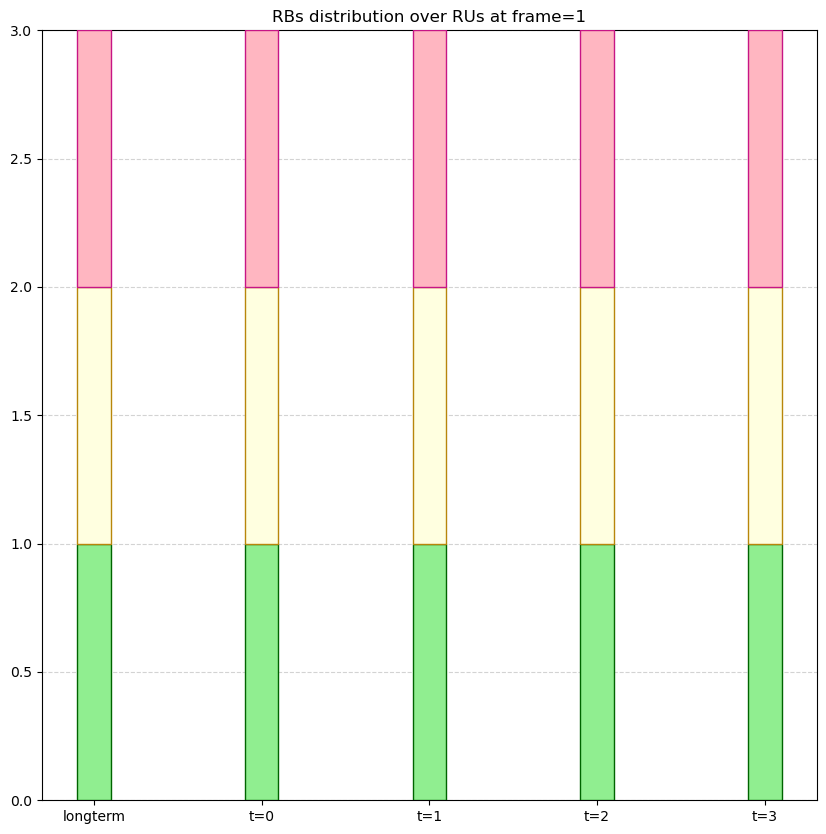

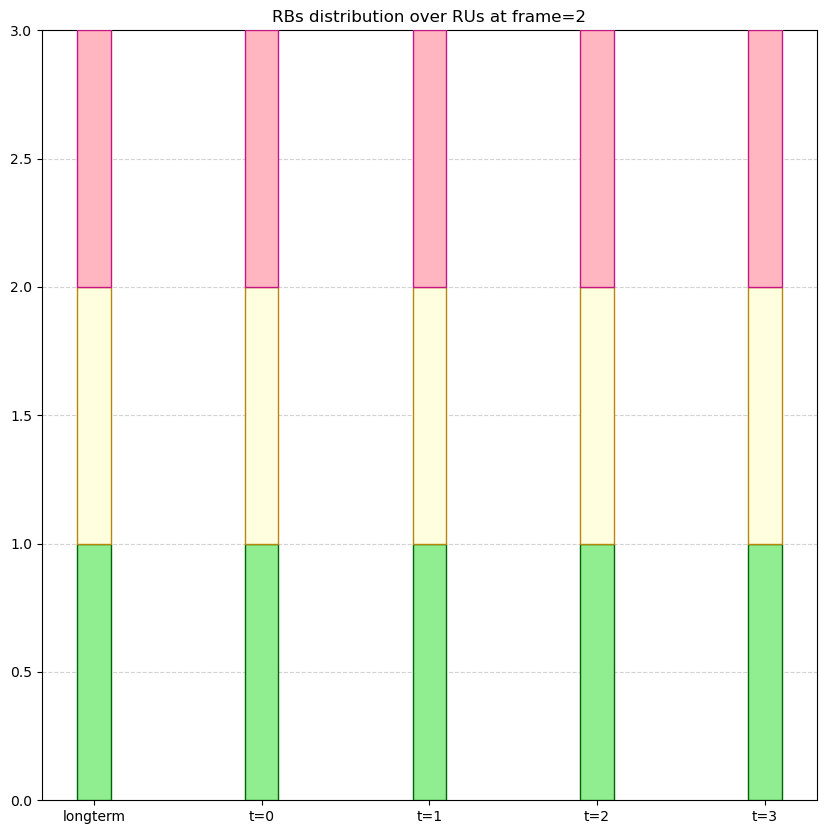

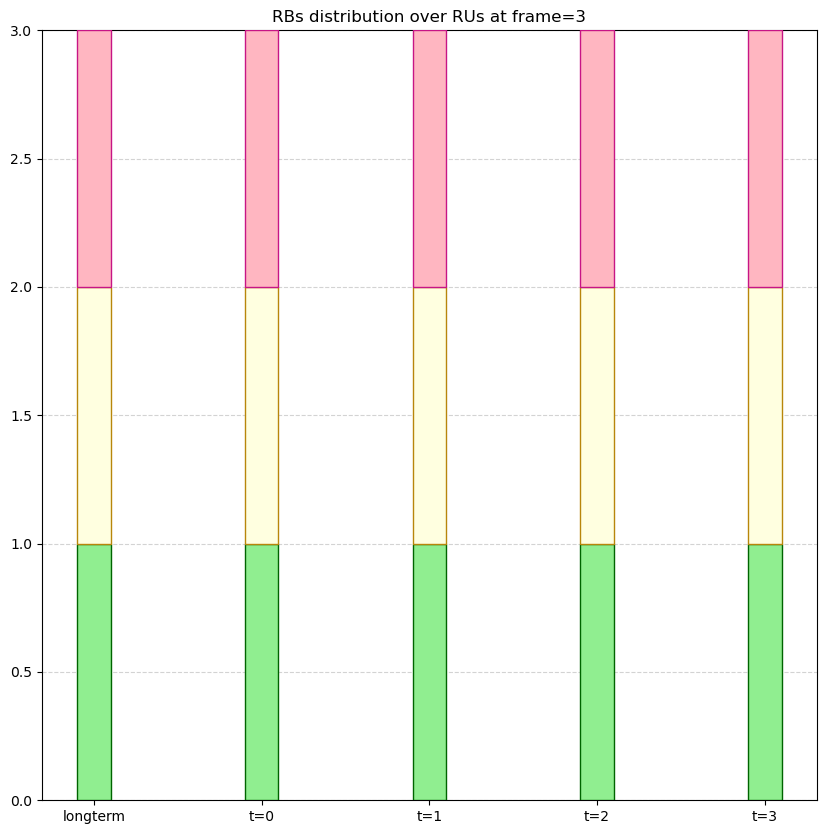

In [174]:
# RB used (power)
x_step = 50
bar_width = 10
for f in range(N_FRAMES):
    plt.figure(figsize=(10,10), dpi=100)
    x_ticks = []
    x = 0
    rb_counts = []
    longterm_solution = solution_longterm_frames[f]
    pi_sk, z_ib_sk, p_ib_sk, mu_ib_sk, phi_i_sk, phi_j_sk, phi_m_sk = longterm_solution
    for i in range(len(z_ib_sk)):
        rb_count = 0
        for b in range(len(z_ib_sk[i])):
            for s in range(len(z_ib_sk[i][b])):
                for k in range(len(z_ib_sk[i][b][s])):
                    if round(z_ib_sk[i,b,s,k].value) > 0:
                        rb_count += 1
        rb_counts.append(rb_count)
        plt.bar(x, rb_count, width=bar_width, bottom=sum(rb_counts[:i]) if i>0 else 0, hatch='', color=FILL_COLORS[i], edgecolor=RU_COLORS[i], zorder=10)
    x_ticks.append((x, 'longterm'))
    for t in range(N_SLOTS):
        x += x_step
        rb_counts = []
        shortterm_solution = solution_shortterm_slots_frames[f][t]
        short_pi_sk, short_z_ib_sk, short_p_ib_sk, short_mu_ib_sk = shortterm_solution
        for i in range(len(short_z_ib_sk)):
            rb_count = 0
            for b in range(len(short_z_ib_sk[i])):
                for s in range(len(short_z_ib_sk[i][b])):
                    for k in range(len(short_z_ib_sk[i][b][s])):
                        if round(short_z_ib_sk[i,b,s,k].value) > 0:
                            rb_count += 1
            rb_counts.append(rb_count)
            plt.bar(x, rb_count, width=bar_width, bottom=sum(rb_counts[:i]) if i>0 else 0, hatch='', color=FILL_COLORS[i], edgecolor=RU_COLORS[i], zorder=10)
        x_ticks.append((x, f"t={t}"))
        # print(x, rb_count)
    plt.xticks(ticks=[h[0] for h in x_ticks], labels=[h[1] for h in x_ticks])
    plt.ylim([0, N_RBS])
    plt.title(f"RBs distribution over RUs at frame={f}")
    plt.grid(color='lightgrey', linestyle='--', zorder=1)
    plt.show()

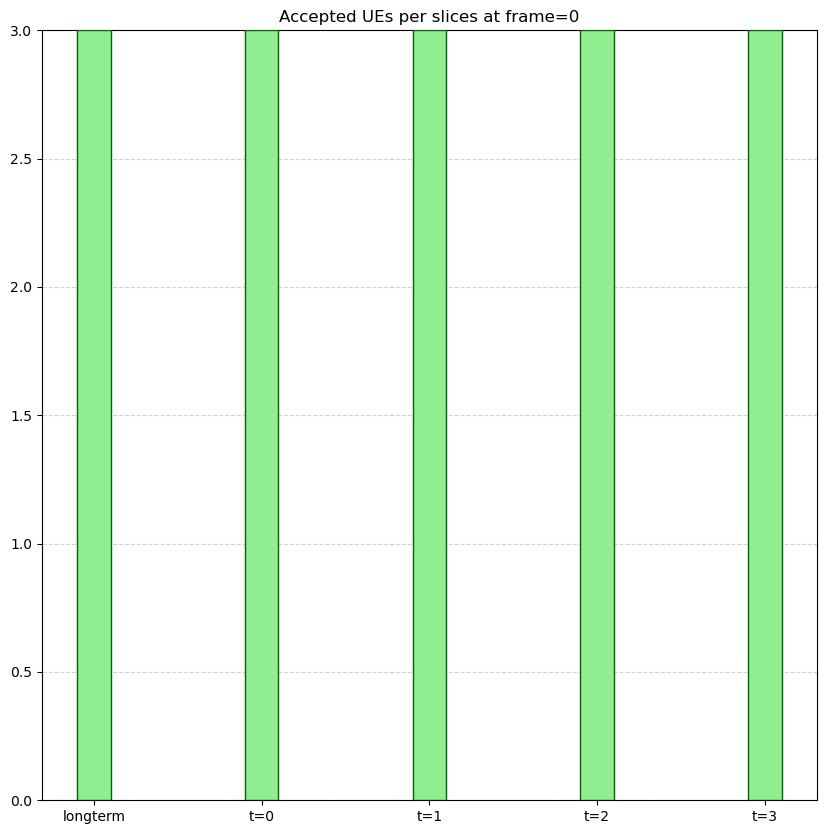

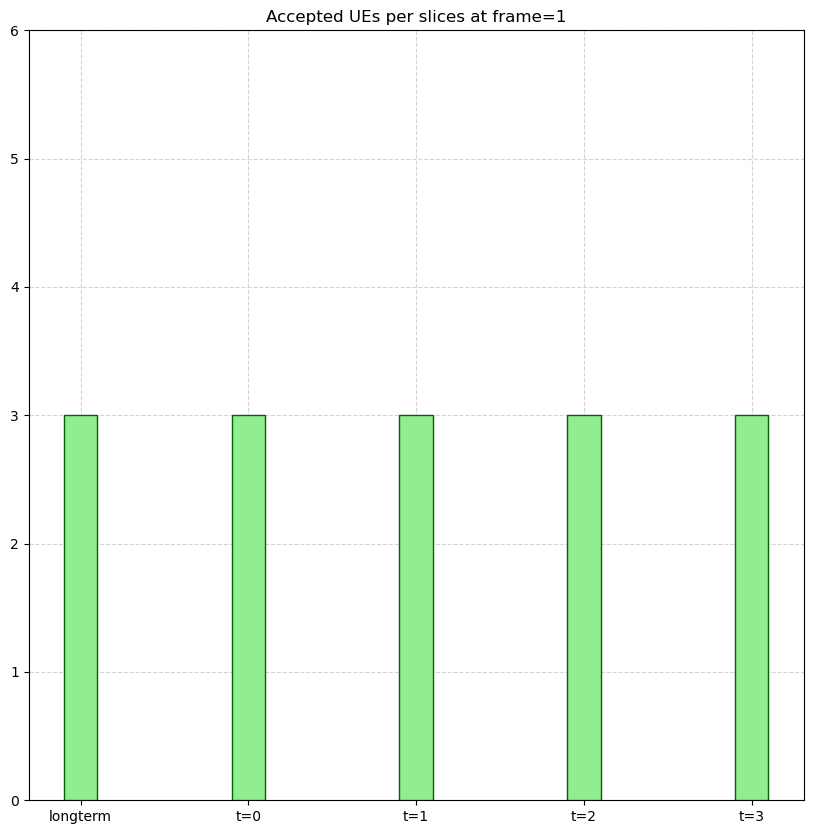

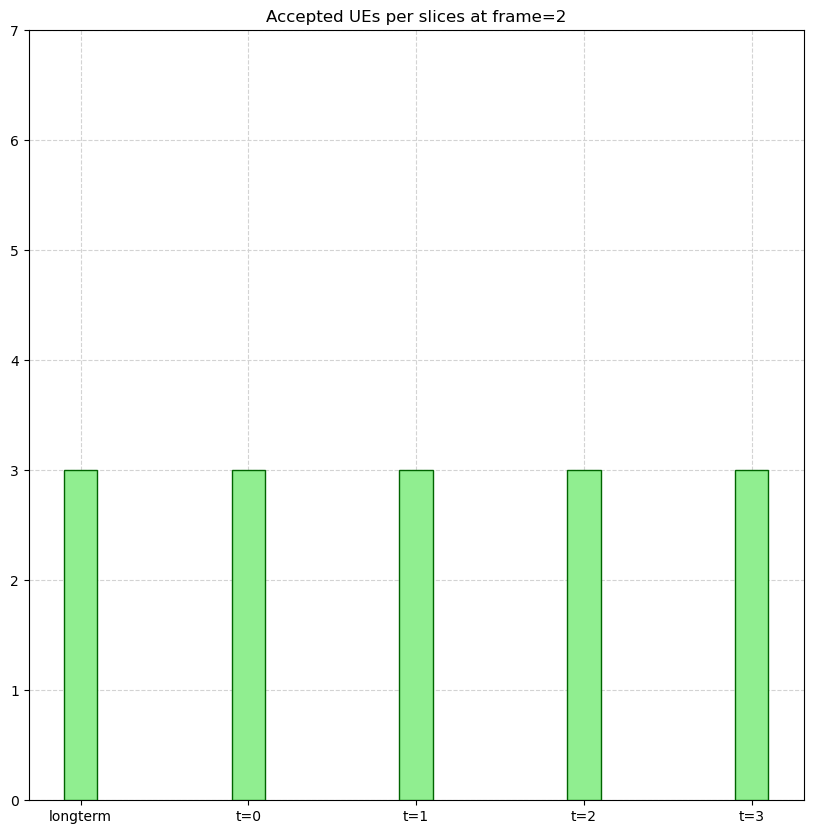

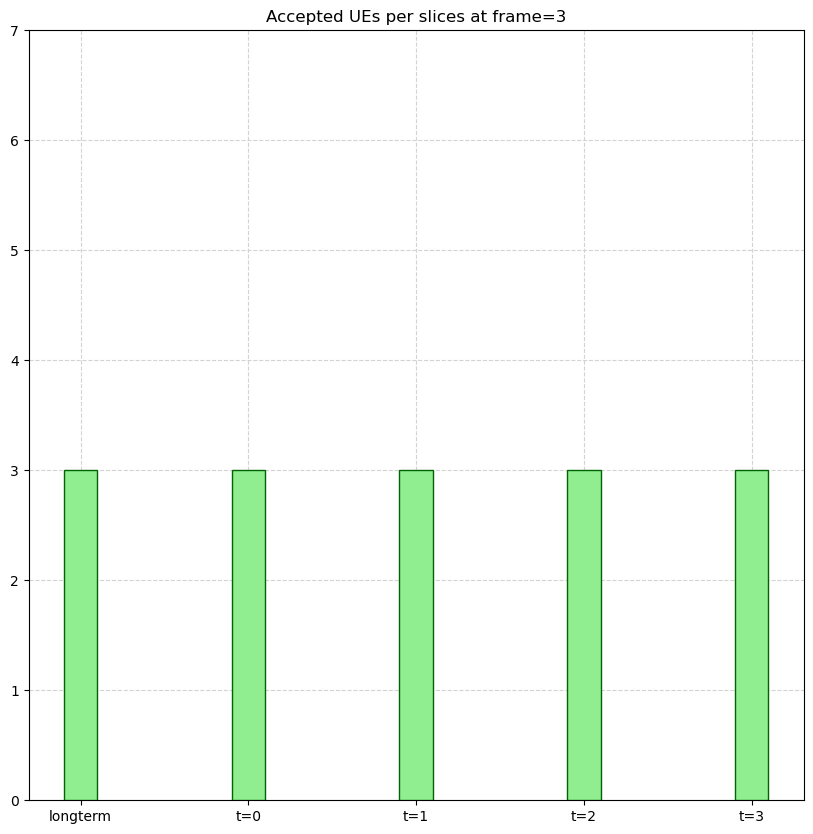

In [175]:

# accepted ues (power)
x_step = 50
bar_width = 10
for f in range(N_FRAMES):
    plt.figure(figsize=(10,10), dpi=100)
    x_ticks = []
    n_ues_frame = []
    x = 0
    longterm_solution = solution_longterm_frames[f]
    pi_sk, z_ib_sk, p_ib_sk, mu_ib_sk, phi_i_sk, phi_j_sk, phi_m_sk = longterm_solution
    for s in range(pi_sk.shape[0]):
        n_ues = sum([v.value for v in pi_sk[s]])
        n_ues_frame.append(n_ues)
        plt.bar(x, n_ues, width=bar_width, bottom=sum(n_ues_frame[:s]) if s>0 else 0, hatch='', color=FILL_COLORS[s], edgecolor=RU_COLORS[s], zorder=10)
    x_ticks.append((x, 'longterm'))
    for t in range(N_SLOTS):
        x += x_step
        n_ue_slot = []
        shortterm_solution = solution_shortterm_slots_frames[f][t]
        short_pi_sk, short_z_ib_sk, short_p_ib_sk, short_mu_ib_sk = shortterm_solution
        for s in range(short_pi_sk.shape[0]):
            n_ues = sum([v.value for v in short_pi_sk[s]])
            n_ue_slot.append(n_ues)
            plt.bar(x, n_ues, width=bar_width, bottom=sum(n_ue_slot[:s]) if s>0 else 0, hatch='', color=FILL_COLORS[s], edgecolor=RU_COLORS[s], zorder=10)
        x_ticks.append((x, f"t={t}"))
        # print(x, rb_count)
    plt.xticks(ticks=[h[0] for h in x_ticks], labels=[h[1] for h in x_ticks])
    plt.ylim([0, pi_sk.shape[1]])
    plt.title(f"Accepted UEs per slices at frame={f}")
    plt.grid(color='lightgrey', linestyle='--', zorder=1)
    plt.show()

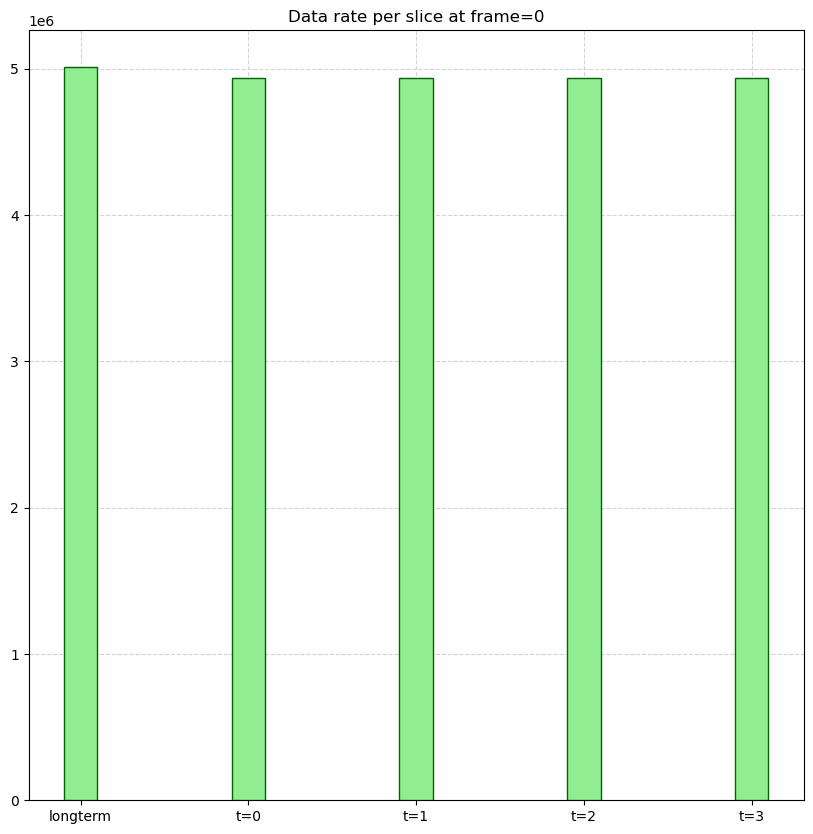

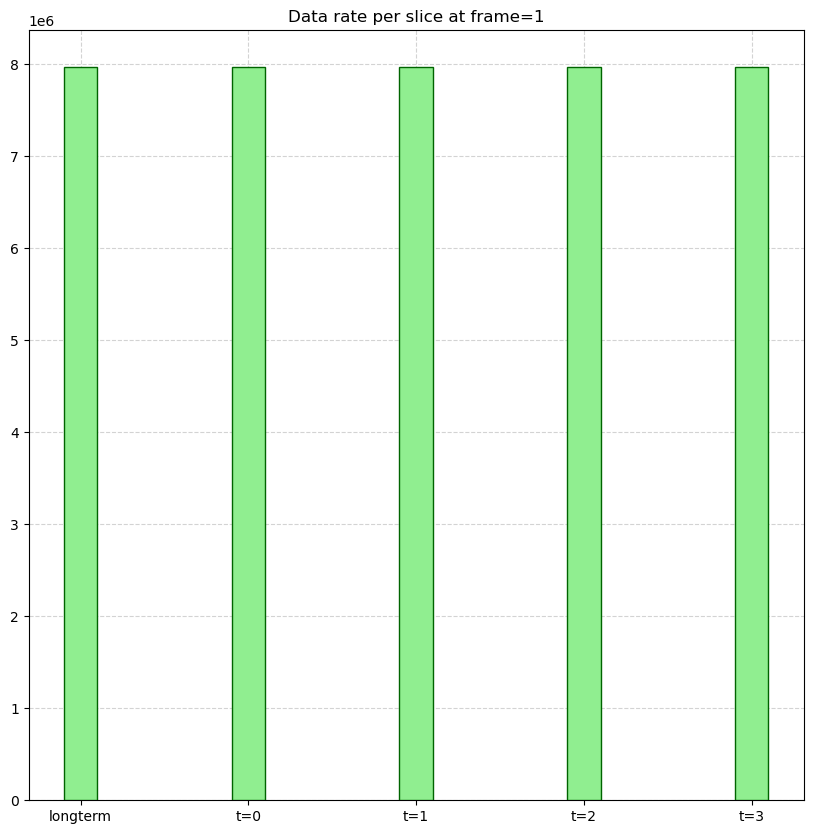

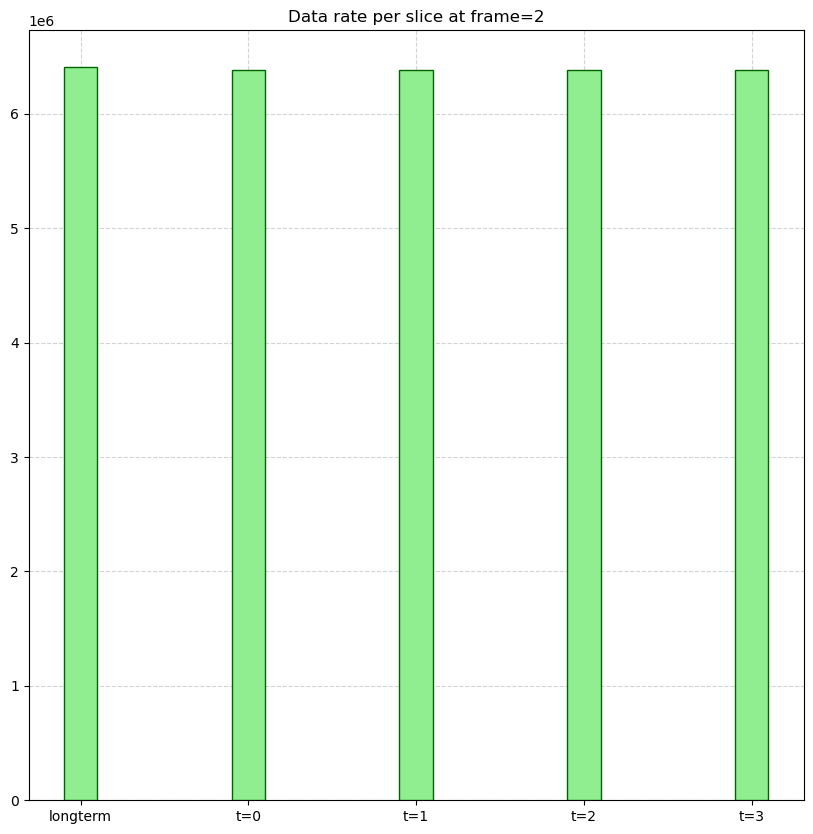

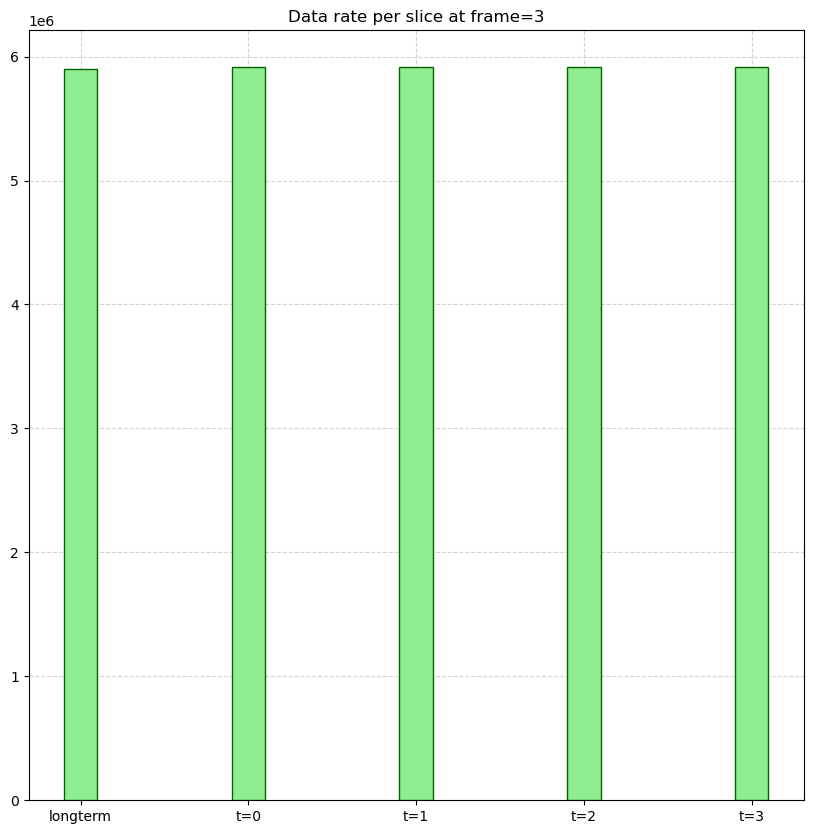

In [176]:
# DATA RATE
rb_bandwidth = 180e3
x_step = 50
bar_width = 10
for f in range(N_FRAMES):
    plt.figure(figsize=(10,10), dpi=100)
    x_ticks = []
    x = 0
    longterm_solution = solution_longterm_frames[f]
    pi_sk, z_ib_sk, p_ib_sk, mu_ib_sk, phi_i_sk, phi_j_sk, phi_m_sk = longterm_solution
    gain = gain_frames[f]
    R_s_frame = []
    for s in range(mu_ib_sk.shape[2]):
        R_s = 0
        for k in range(mu_ib_sk.shape[3]):
            R_sk = sum([rb_bandwidth * math.log(1 + sum([gain[i, b, s, k] * mu_ib_sk[i, b, s, k].value for i in range(mu_ib_sk.shape[0])])) / np.log(2) for b in range(mu_ib_sk.shape[1])])
            R_s += R_sk
        R_s_frame.append(R_s)
        plt.bar(x, R_s, width=bar_width, bottom=sum(R_s_frame[:s]) if s>0 else 0, hatch='', color=FILL_COLORS[s], edgecolor=RU_COLORS[s], zorder=10)
    x_ticks.append((x, 'longterm'))
    for t in range(N_SLOTS):
        x += x_step
        shortterm_solution = solution_shortterm_slots_frames[f][t]
        short_pi_sk, short_z_ib_sk, short_p_ib_sk, short_mu_ib_sk = shortterm_solution
        R_s_slot = []
        for s in range(mu_ib_sk.shape[2]):
            R_s = 0
            for k in range(mu_ib_sk.shape[3]):
                R_sk = sum([rb_bandwidth * math.log(1 + sum([gain[i, b, s, k] * short_mu_ib_sk[i, b, s, k].value for i in range(mu_ib_sk.shape[0])])) / np.log(2) for b in range(short_mu_ib_sk.shape[1])])
                R_s += R_sk
            R_s_slot.append(R_s)
            plt.bar(x, R_s, width=bar_width, bottom=sum(R_s_slot[:s]) if s>0 else 0, hatch='', color=FILL_COLORS[s], edgecolor=RU_COLORS[s], zorder=10)
        x_ticks.append((x, f't={t}'))
        
    plt.xticks(ticks=[h[0] for h in x_ticks], labels=[h[1] for h in x_ticks])
    # plt.ylim([0, N_RBS])
    plt.title(f"Data rate per slice at frame={f}")
    plt.grid(color='lightgrey', linestyle='--', zorder=1)
    plt.show()